In [3]:
import requests
import pandas as pd
import numpy as np
import argparse
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
import os

# os.environ['KMP_DUPLICATE_LIB_OK']='True'

import torch
import torch.nn as nn

In [4]:
API_BASE_URL='https://clinicaltrials.gov/api/query'
EXAMPLE_DRUG = 'gabapentin'

## Make Data into Tables

In [5]:
def get_studies_by_expression(expression):
    r = requests.get(API_BASE_URL + '/full_studies?expr={expr}&min_rnk=1&max_rnk=99&fmt=json'
                     .format(expr=expression))
    return r.json()


def get_conditions_for_drug(drug):
    r = requests.get(API_BASE_URL + '/field_values?expr={drug}&field=ConditionAncestorTerm&fmt=json'
                     .format(drug=drug))
    
    return r.json()


def get_all_studies(expr, results=True):
    og_length = 99
    studies = []
    count = 0
    while (og_length >= 99):
        r = requests.get(API_BASE_URL + '/full_studies?expr={expr}&min_rnk={min_rank}&max_rnk={max_rank}&fmt=json'
                         .format(expr=expr, min_rank=count*99 + 1, max_rank=(count*99+1)+98))
        og_length = len(r.json()['FullStudiesResponse'].get('FullStudies', []))
        new_studies = r.json()['FullStudiesResponse'].get('FullStudies', [{'Study': []}])
        studies += list(filter(lambda x: 'ResultsSection' in x['Study'] and 'OutcomeMeasuresModule' in x['Study']['ResultsSection'], new_studies))
        count+=1
        
    return studies

studies = get_all_studies(EXAMPLE_DRUG)

In [27]:
def create_studies_table(studies):
    buffer = {
        'study_id': [], 'official_title': [], 'short_title':[], 'conditions': [], 
        'verified_date': [], 'responsible_party': [], 'sponsor':[], 'type': [], 'description': [],
        'interventions': [], 'purpose': [], 'intervention_type': [], 'mesh_terms': [],
        'criteria': [], 'min_age': [], 'max_age': [], 'gender': []}
    for i, study in enumerate(studies):


        try:
            buffer['study_id'].append(study['Study']['ProtocolSection']['IdentificationModule']['NCTId'])
        except KeyError as e:
            buffer['study_id'].append('NA')

        try:
            buffer['official_title'].append(study['Study']['ProtocolSection']['IdentificationModule']['OfficialTitle'])
        except KeyError as e:
            buffer['official_title'].append('NA')
            
        try:
            buffer['short_title'].append(study['Study']['ProtocolSection']['IdentificationModule']['OfficialTitle'])
        except KeyError as e:
            buffer['short_title'].append('NA')

        try:
            buffer['verified_date'].append(study['Study']['ProtocolSection']['StatusModule']['StatusVerifiedDate'])
        except KeryError as e:
            buffer['verified_date'].append('NA')

        try:
            buffer['responsible_party'].append(study['Study']['ProtocolSection']['SponsorCollaboratorsModule']['ResponsibleParty']['ResponsiblePartyInvestigatorFullName'])
        except KeyError as e:
            buffer['responsible_party'].append('NA')
            
        try:
            buffer['sponsor'].append(study['Study']['ProtocolSection']['SponsorCollaboratorsModule']['LeadSponsor']['LeadSponsorName'])
        except KeyError as e:
            buffer['sponsor'].append('NA')

        try: 
            buffer['conditions'].append(study['Study']['ProtocolSection']['ConditionsModule']['ConditionList']['Condition'])
        except KeyError as e:
            buffer['conditions'].append('NA')

        try:
            buffer['type'].append(study['Study']['ProtocolSection']['DesignModule']['StudyType'])
        except KeyError as e:
            buffer['type'].append('NA')
        
        try:
            buffer['purpose'].append(study['Study']['ProtocolSection']['DesignModule']['DesignInfo'].get('DesignPrimaryPurpose', 'NA'))
        except KeyError as e:
            buffer['purpose'].append('NA')
            
        try:
            buffer['intervention_type'].append(study['Study']['ProtocolSection']['DesignModule']['DesignInfo'].get('DesignInterventionModel', 'NA'))
        except KeyError as e:
            buffer['intervention_type'].append('NA')
        
        try:
            buffer['mesh_terms'].append([x.get('ConditionMeshTerm', 'NA') for x in study['Study']['DerivedSection']['ConditionBrowseModule']['ConditionMeshList']['ConditionMesh']])
        except KeyError as e:
            buffer['mesh_terms'].append([])
            
        try:
            buffer['description'].append(study['Study']['ProtocolSection']['DescriptionModule']['DetailedDescription'])
        except KeyError as e:
            buffer['description'].append('NA')
            
        try: 
            buffer['interventions'].append([x.get('InterventionMeshTerm', 'NA') for x in study['Study']['DerivedSection']['InterventionBrowseModule']['InterventionMeshList']['InterventionMesh']])
        except KeyError as e:
            buffer['interventions'].append([])
            
        try:
            buffer['criteria'].append(study['Study']['ProtocolSection']['EligibilityModule']['EligibilityCriteria'])
        except KeyError as e:
            buffer['criteria'].append('NA')
            
        try:
            buffer['gender'].append(study['Study']['ProtocolSection']['EligibilityModule']['Gender'])
        except KeyError as e:
            buffer['gender'].append('NA')
        
        try:
            buffer['min_age'].append(study['Study']['ProtocolSection']['EligibilityModule']['MinimumAge'])
        except KeyError as e:
            buffer['min_age'].append('NA')
            
        try:
            buffer['max_age'].append(study['Study']['ProtocolSection']['EligibilityModule']['MaximumAge'])
        except KeyError as e:
            buffer['max_age'].append('NA')
    return buffer


def create_groups_table(studies): # The groups in the baseline -> this might end up badly 
    groups_df = { 
        'name': [],
        'study_id': [],
        'id': [],
        'description': [],
        'participants': [],
        'maybe_arm_type': []
    }
    parts = []
    for study in studies:
        study_id = study['Study']['ProtocolSection']['IdentificationModule']['NCTId']
        groups = []
        denoms = []
        try: 
            groups = study['Study']['ResultsSection']['BaselineCharacteristicsModule']['BaselineGroupList']['BaselineGroup']
        except KeyError as e:
            groups = []
            
        # Get the type of groups from arm 
        arms = study['Study']['ProtocolSection']['ArmsInterventionsModule']['ArmGroupList'].get('ArmGroup', [])
        types = []
        for arm in arms:
            label = arm.get('ArmGroupLabel', None)
            armType = arm.get('ArmGroupType', None)
            types.append(armType)
            
        for i, group in enumerate(groups):
            groups_df['name'].append(group.get('BaselineGroupTitle', 'NA'))
            groups_df['study_id'].append(study_id)
            groups_df['id'].append(group.get('BaselineGroupId', 'NA'))
            groups_df['description'].append(group.get('BaselineGroupDescription', 'NA'))
            groups_df['maybe_arm_type'].append(types[i] if i<len(types)else 'NA')
                
        try:
            denoms = study['Study']['ResultsSection']['BaselineCharacteristicsModule']['BaselineDenomList']['BaselineDenom']
        except KeyError as e:
            denoms = []
            
        participants = list(filter(lambda x: x.get('BaselineDenomUnits', 'NA') == 'Participants', denoms))
        for participant in participants[0]['BaselineDenomCountList']['BaselineDenomCount']:
            groups_df['participants'].append(int(participant['BaselineDenomCountValue']))
            
    return groups_df, parts


def create_arms_table(studies):
    arms_df = {
        'study_id': [],
        'name': [],
        'type': [],
        'description': [],
    }
    
    for study in studies:
        study_id = study['Study']['ProtocolSection']['IdentificationModule']['NCTId']
        for arm in study['Study']['ProtocolSection']['ArmsInterventionsModule'].get('ArmGroupList', {'ArmGroup':[]})['ArmGroup']:
            arms_df['study_id'].append(study_id)
            arms_df['name'].append(arm.get('ArmGroupLabel', 'NA'))
            arms_df['type'].append(arm.get('ArmGroupType', 'NA'))
            arms_df['description'].append(arm.get('ArmGroupDescription', 'NA'))
    
    return arms_df

def create_interventions_table(studies):
    int_df = {
        'study_id':[],
        'name': [],
        'type': [],
        'description': [],
        'arms': [] # A list of arms that this was used on
    }
    
    for study in studies:
        study_id = study['Study']['ProtocolSection']['IdentificationModule']['NCTId']
        for intervention in study['Study']['ProtocolSection']['ArmsInterventionsModule'].get('InterventionList', {'Intervention':[]})['Intervention']:
            int_df['study_id'].append(study_id)
            int_df['name'].append(intervention.get('InterventionName', 'NA'))
            int_df['type'].append(intervention.get('InterventionType', 'NA'))
            int_df['description'].append(intervention.get('InterventionDescription', 'NA'))
            int_df['arms'].append(intervention.get('InterventionArmGroupLabelList', {'InterventionArmGroupLabel': []})['InterventionArmGroupLabel'])

    return int_df
    


def get_outcome_modules(studies):
    outcome_modules = []
    for study in studies:
        if 'OutcomeMeasuresModule' in study['Study']['ResultsSection']:
            outcome_modules.append(study['Study']['ResultsSection']['OutcomeMeasuresModule'])
            continue 
        print('No Results: ', study['Study']['ProtocolSection']['IdentificationModule']['OfficialTitle'])
        
    return outcome_modules


def create_measures_table(studies):
    outcome_modules = get_outcome_modules(studies)
    df = {
        'study_id': [],
        'measure': [],
        'type': [],
        'description': [],
        'dispersion_param': [],
        'measure_param': [],
        'units': []
    }
    
    for i, module in enumerate(outcome_modules):
        study_id = studies[i]['Study']['ProtocolSection']['IdentificationModule']['NCTId']
        for measure in module['OutcomeMeasureList']['OutcomeMeasure']:
            df['type'].append(measure.get('OutcomeMeasureType', 'NA'))
            df['measure'].append(measure.get('OutcomeMeasureTitle', 'NA'))
            df['description'].append(measure.get('OutcomeMeasureDescription', 'NA'))
            df['measure_param'].append(measure.get('OutcomeMeasureParamType', 'NA'))
            df['dispersion_param'].append(measure.get('OutcomeMeasureDispersionType', 'NA'))
            df['units'].append(measure.get('OutcomeMeasureUnitOfMeasure', 'NA'))
            df['study_id'].append(study_id)
            
    return df 


def create_outcomes_table(studies):
    outcome_modules = get_outcome_modules(studies)
    admin_df = {
        'study_id': [],
        'group_id': [],
        'measure': [],
        'title': [],
        'description': [],
    }
    
    outcome_df = {
        'study_id': [],
        'group_title': [],
        'measure': [],
        'title': [],
        'value': [],
        'dispersion': [],
        'upper': [],
        'lower': [],
        'participants': []
    }
    
    for i, module in enumerate(outcome_modules):
        study_id = studies[i]['Study']['ProtocolSection']['IdentificationModule']['NCTId']
        for measure in module['OutcomeMeasureList']['OutcomeMeasure']:
            try:
                overall_group_to_no = {}
                for denom in measure.get('OutcomeDenomList', {'OutcomeDenom': []})['OutcomeDenom']:
                    if denom.get('OutcomeDenomUnits', 'NA') == 'Participants':
                        for count in denom.get('OutcomeDenomCountList', {'OutcomeDenomCount': []})['OutcomeDenomCount']:
                            overall_group_to_no[count['OutcomeDenomCountGroupId']] = count['OutcomeDenomCountValue']
                
                group_to_title = {}
                for admin in measure.get('OutcomeGroupList', {'OutcomeGroup': []})['OutcomeGroup']:
                    admin_df['study_id'].append(study_id)
                    admin_df['group_id'].append(admin.get('OutcomeGroupId', 'NA'))
                    admin_df['measure'].append(measure.get('OutcomeMeasureTitle', 'NA'))
                    admin_df['title'].append(admin.get('OutcomeGroupTitle', 'NA'))
                    admin_df['description'].append(admin.get('OutcomeGroupDescription', 'NA'))
                    group_to_title[admin.get('OutcomeGroupId', 'NA')] = admin.get('OutcomeGroupTitle', 'NA')
                    
                # Sometimes the participants are just listed one time before all the others - not just in the class
                for group in measure.get('OutcomeClassList', {'OutcomeClass': []})['OutcomeClass']:
    
                    group_to_no = {}
                    for denom in group.get('OutcomeClassDenomList', {'OutcomeClassDenom': []})['OutcomeClassDenom']:
                        for count in denom.get('OutcomeClassDenomCountList', {'OutcomeClassDenomCount': []})['OutcomeClassDenomCount']:
                            group_to_no[count['OutcomeClassDenomCountGroupId']] = count['OutcomeClassDenomCountValue']

                    for cat in group.get('OutcomeCategoryList', {'OutcomeCategory': []})['OutcomeCategory']:
                        for outcome in cat['OutcomeMeasurementList']['OutcomeMeasurement']:
                            outcome_df['study_id'].append(study_id)
                            outcome_df['group_title'].append(group_to_title[outcome.get('OutcomeMeasurementGroupId', 'NA')])
                            outcome_df['measure'].append(measure.get('OutcomeMeasureTitle', 'NA'))
                            outcome_df['value'].append(outcome.get('OutcomeMeasurementValue', 'NA'))
                            outcome_df['dispersion'].append(outcome.get('OutcomeMeasurementSpread', 'NA'))
                            outcome_df['upper'].append(outcome.get('OutcomeMeasurementUpperLimit', 'NA'))
                            outcome_df['lower'].append(outcome.get('OutcomeMeasurementLowerLimit', 'NA'))
                            outcome_df['participants'].append(group_to_no.get(outcome.get('OutcomeMeasurementGroupId', 'NA'), None) or overall_group_to_no.get(outcome.get('OutcomeMeasurementGroupId', 'NA'), 'NA'))
                            outcome_df['title'].append(group.get('OutcomeClassTitle', 'NA'))
                        
                    
            except KeyError as e:
                print(e)
                continue
                
    return (admin_df, outcome_df)


def create_analytics_table(studies):
    outcome_modules = get_outcome_modules(studies)
    df = {
        'study_id': [],
        'measure': [],
        'groups': [],
        'description': [], # may or may not be the outcome title
        'method': [],
        'param_type': [],
        'fromStudy': [],
        'pval': [],
        'group_titles': []
    }
    
    for i, module in enumerate(outcome_modules):
        study_id = studies[i]['Study']['ProtocolSection']['IdentificationModule']['NCTId']
        for measure in module['OutcomeMeasureList']['OutcomeMeasure']:
            group_to_title = {}
            for group in measure.get('OutcomeGroupList', {'OutcomeGroup': []})['OutcomeGroup']:
                if group['OutcomeGroupId'] not in group_to_title:
                    group_to_title[group['OutcomeGroupId']] = 'NA'
                group_to_title[group['OutcomeGroupId']] = group.get('OutcomeGroupTitle', 'NA')
                    
            measure_title = measure.get('OutcomeMeasureTitle', 'NA')
            for stat in measure.get('OutcomeAnalysisList', {'OutcomeAnalysis': []})['OutcomeAnalysis']:
                df['study_id'].append(study_id)
                df['measure'].append(measure_title)
                df['groups'].append(stat.get('OutcomeAnalysisGroupIdList', {'OutcomeAnalysisGroupId': []})['OutcomeAnalysisGroupId'])
                df['description'].append(stat.get('OutcomeAnalysisGroupDescription', 'NA'))
                df['method'].append(stat.get('OutcomeAnalysisStatisticalMethod', 'NA'))
                df['param_type'].append(stat.get('OutcomeAnalysisParamType', 'NA'))
                df['fromStudy'].append(True)
                df['pval'].append(stat.get('OutcomeAnalysisPValue', 'NA'))
                df['group_titles'].append(dict([(g, group_to_title.get(g, 'NA')) for g in stat.get('OutcomeAnalysisGroupIdList', {'OutcomeAnalysisGroupId': []})['OutcomeAnalysisGroupId']]))
    return df


def create_effects_table(studies, drug):
    df = {
        'drug': [],
        'study_id': [],
        'group_id': [],
        'effect_name': [],
        'type': [], #Serious or other
        'organ_system': [],
        'assesment': [],
        'no_effected': [],
        'collection_threshold': []
    }
    for i, study in enumerate(studies):
        study_id = study['Study']['ProtocolSection']['IdentificationModule']['NCTId']
        adverse_module = study['Study']['ResultsSection'].get('AdverseEventsModule', {}) #Small risk here
        for event in adverse_module.get('OtherEventList', {'OtherEvent': []})['OtherEvent']:
            for stat in event.get('OtherEventStatsList', {'OtherEventStats': []})['OtherEventStats']:
                df['drug'].append(drug)
                df['study_id'].append(study_id)
                df['group_id'].append(stat.get('OtherEventStatsGroupId', 'NA'))
                df['effect_name'].append(event.get('OtherEventTerm', 'NA'))
                df['type'].append('other')
                df['organ_system'].append(event.get('OtherEventOrganSystem', 'NA'))
                df['assesment'].append(event.get('OtherEventAssessmentType', 'NA'))
                df['no_effected'].append(float(stat.get('OtherEventStatsNumAffected', 0)) or float(stat.get('OtherEventStatsNumEvents', 0)))
                df['collection_threshold'].append(float(adverse_module.get('EventsFrequencyThreshold', -1)))
    return df

def create_analytics_table(studies):
    outcome_modules = get_outcome_modules(studies)
    df = {
        'study_id': [],
        'measure': [],
        'groups': [],
        'description': [], # may or may not be the outcome title
        'method': [],
        'param_type': [],
        'fromStudy': [],
        'pval': [],
        'group_titles': []
    }
    
    for i, module in enumerate(outcome_modules):
        study_id = studies[i]['Study']['ProtocolSection']['IdentificationModule']['NCTId']
        for measure in module['OutcomeMeasureList']['OutcomeMeasure']:
            group_to_title = {}
            for group in measure.get('OutcomeGroupList', {'OutcomeGroup': []})['OutcomeGroup']:
                if group['OutcomeGroupId'] not in group_to_title:
                    group_to_title[group['OutcomeGroupId']] = 'NA'
                group_to_title[group['OutcomeGroupId']] = group.get('OutcomeGroupTitle', 'NA')
                    
            measure_title = measure.get('OutcomeMeasureTitle', 'NA')
            for stat in measure.get('OutcomeAnalysisList', {'OutcomeAnalysis': []})['OutcomeAnalysis']:
                df['study_id'].append(study_id)
                df['measure'].append(measure_title)
                df['groups'].append(stat.get('OutcomeAnalysisGroupIdList', {'OutcomeAnalysisGroupId': []})['OutcomeAnalysisGroupId'])
                df['description'].append(stat.get('OutcomeAnalysisGroupDescription', 'NA'))
                df['method'].append(stat.get('OutcomeAnalysisStatisticalMethod', 'NA'))
                df['param_type'].append(stat.get('OutcomeAnalysisParamType', 'NA'))
                df['fromStudy'].append(True)
                df['pval'].append(stat.get('OutcomeAnalysisPValue', 'NA'))
                df['group_titles'].append(dict([(g, group_to_title.get(g, 'NA')) for g in stat.get('OutcomeAnalysisGroupIdList', {'OutcomeAnalysisGroupId': []})['OutcomeAnalysisGroupId']]))
    return df


def create_criteria_table(studies):
    df = {
        'study_id': [],
        'criteria': [],
        'type': []
    }
    
    for study in studies:
        study_id = study['Study']['ProtocolSection']['IdentificationModule']['NCTId']
        criteria_str = study['Study']['ProtocolSection']['EligibilityModule']['EligibilityCriteria']
        tokens = [x for x in criteria_str.split('\n') if x != '']
        mode = None
        for sent in tokens: # Let's go for 0 FP at the expense of higher FN
            
            if 'inclusion criteria' in sent.lower():
                mode = 'inclusion'
                continue
            if 'exclusion criteria' in sent.lower():
                mode = 'exclusion' 
                continue
            if mode:
                df['criteria'].append(sent)
                df['type'].append(mode)
                df['study_id'].append(study_id)
                
    return df
        

In [28]:
sent = 'Inclusion Criteria:\n\nWomen seeking surgical abortion between 5 and 23 6/7 weeks of ultrasound age.\nEnglish or Spanish speaking\neligible for office-based surgical pregnancy termination\n\nExclusion Criteria:\n\npresent use of gabapentin or pregabalin,\nrenal disease\nsensitivity or allergy to gabapentin\nMissed abortion'

[x for x in sent.split('\n') if x != '']

['Inclusion Criteria:',
 'Women seeking surgical abortion between 5 and 23 6/7 weeks of ultrasound age.',
 'English or Spanish speaking',
 'eligible for office-based surgical pregnancy termination',
 'Exclusion Criteria:',
 'present use of gabapentin or pregabalin,',
 'renal disease',
 'sensitivity or allergy to gabapentin',
 'Missed abortion']

In [29]:
def create_all_tables(drug):
    studies_table = pd.DataFrame.from_dict(create_studies_table(studies))
    groups_table = pd.DataFrame.from_dict(create_groups_table(studies)[0])
    arms_table = pd.DataFrame.from_dict(create_arms_table(studies))
    int_table = pd.DataFrame.from_dict(create_interventions_table(studies))
    measures_table = pd.DataFrame.from_dict(create_measures_table(studies))
    admin_df, outcome_df = create_outcomes_table(studies)
    admins_table = pd.DataFrame.from_dict(admin_df)
    outcomes_table = pd.DataFrame.from_dict(outcome_df)
    analytics = pd.DataFrame.from_dict(create_analytics_table(studies))

    return studies_table, groups_table, measures_table, admins_table, outcomes_table, analytics, int_table, arms_table

studies_table, groups_table, measures_table, admins_table, outcomes_table, analytics_table, int_table, arms_table = create_all_tables(EXAMPLE_DRUG)


In [42]:
# So it is actually not accurate to put the number of participants into a group because it changes
# between measures and over the course of a measure
groups_table

,name,study_id,id,description,participants,maybe_arm_type
0,"Gabapentin, Then Placebo",NCT01675960,BG000,Participants first receive gabapentin 3 times ...,2,Experimental
1,"Placebo, Then Gabapentin",NCT01675960,BG001,Participants first receive placebo 3 times per...,0,Experimental
2,Total,NCT01675960,BG002,Total of all reporting groups,2,NA
3,Gabapentin,NCT02359110,BG000,Patients will receive Gabapentin 300mg tab les...,55,Experimental
4,Placebo,NCT02359110,BG001,Patients will receive Methylcellulose based pl...,54,Placebo Comparator
...,...,...,...,...,...,...
387,Total,NCT03964649,BG010,Total of all reporting groups,7308,NA
388,A: Localized Resectable Disease,NCT00667342,BG000,Stratum A participants had primary tumors pote...,31,Experimental
389,B: Localized Unresectable Disease,NCT00667342,BG001,Participants with localized unresectable prima...,0,Experimental
390,C: Metastatic Tumors,NCT00667342,BG002,Stratum C participants had metastatic tumors.,12,Experimental


In [38]:
# The names of the arms and the outcomes groups aren't always the same
# but we need to link them to get the correct information
# I think we should get some kind of similarity metric going for the two

# This also complicates things with a crossover trial, I think we should hold off on this feature

,study_id,group_id,measure,title,description
0,NCT01675960,OG000,Symptom Relief for Chronic Irritability in Neu...,Gabapentin,Neurotin\n\nGabapentin: The active drug is in ...
1,NCT01675960,OG001,Symptom Relief for Chronic Irritability in Neu...,Placebo,Glycerin based clear solution that is flavored...
2,NCT01675960,OG000,Prevalence of Associated Gastrointestinal and ...,Gabapentin,Neurotin\n\nGabapentin: The active drug is in ...
3,NCT01675960,OG001,Prevalence of Associated Gastrointestinal and ...,Placebo,Glycerin based clear solution that is flavored...
4,NCT02359110,OG000,NRS (Numerical Rating Scale),Gabapentin,Patients will receive Gabapentin 300mg tab les...
...,...,...,...,...,...
2717,NCT00667342,OG001,Median Duration of Neuropathic Pain Medication,Limb Sparing Group,Participants had localized disease at diagnosi...
2718,NCT00667342,OG002,Median Duration of Neuropathic Pain Medication,Entire Study Group,Participants enrolled on the study who met the...
2719,NCT00667342,OG000,Mean Duration of Neuropathic Pain Medication,Amputation Group,Participants had metastatic disease at diagnosis.
2720,NCT00667342,OG001,Mean Duration of Neuropathic Pain Medication,Limb Sparing Group,Participants had localized disease at diagnosi...


<AxesSubplot:>

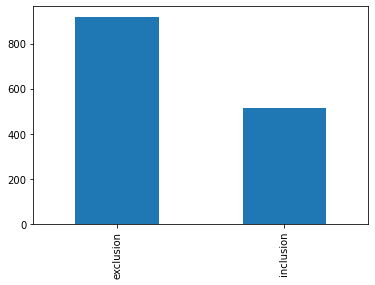

In [8]:
criteria_table['type'].value_counts().plot.bar()

### More Data Sets
- Let's get some more datasets to help BERT along
- Wea

In [5]:
# Get the patient criteria 
studies = []

In [5]:
from os import listdir
from os.path import isfile, join, isdir
import json
# Need to add in MESH terms as a requirement
study_directories = [f for f in listdir('AllAPIJSON/') if isdir(join('AllAPIJSON/', f))]
studies = []
write_counter = 0
for directory in study_directories:
    studyFileNames = [f for f in listdir('AllAPIJSON/'+directory+'/')]
    for file in studyFileNames:
        try:
            with open('AllAPIJSON/'+directory+'/'+file) as f:
                data = json.load(f)['FullStudy']
                has_results = 'ResultsSection' in data['Study'] and 'OutcomeMeasuresModule' in data['Study']['ResultsSection']
                interventions = [x.get('InterventionMeshTerm', 'NA') for x in data['Study']['DerivedSection']['InterventionBrowseModule']['InterventionMeshList']['InterventionMesh']]
                conditions = data['Study']['ProtocolSection']['ConditionsModule']['ConditionList']['Condition']
                study_type = data['Study']['ProtocolSection']['DesignModule']['StudyType']
                if has_results and interventions and conditions and (study_type == 'Interventional'):
                    studies.append(data)

                f.close()
                
            if len(studies) >= 10000:
                print('writing study', write_counter)
                new_analytics_table = pd.DataFrame.from_dict(create_analytics_table(studies))
                new_analytics_table.to_pickle('int_stats_'+str(write_counter)+'.pkl')
                write_counter += 1
                studies = []

        except KeyError:
            continue

new_analytics_table = pd.DataFrame.from_dict(create_analytics_table(studies))
new_analytics_table.to_pickle('int_stats_'+str(write_counter)+'.pkl')

write_counter += 1
studies = []


writing study 0
writing study 1


In [8]:
# Combine files
intervention_studies_1 = pd.read_pickle('int_studies_1.pkl')
intervention_studies_0 = pd.read_pickle('int_studies_0.pkl')
intervention_studies_2 = pd.read_pickle('int_studies_2.pkl')

In [12]:
intervention_studies = pd.concat([intervention_studies_1, intervention_studies_0, intervention_studies_2]).reset_index(drop=True)

In [15]:
intervention_studies.to_pickle('intervention_studies.pkl')

In [7]:
sample_studies_with_results_and_conditions()

KeyboardInterrupt: 

In [20]:
pd.DataFrame.from_dict(create_studies_table(new_studies, 'NA'))

,study_id,name,drug,conditions,verified_date,responsible_party,type,description,interventions,purpose,intervention_type,mesh_terms
0,NCT03266419,"A Double-blind, Randomized, Parallel Design to...",NA,[Neuromuscular Blockade],October 2019,{'ResponsiblePartyType': 'Principal Investigat...,Interventional,All patients were fasted from midnight without...,[Rocuronium],Treatment,Parallel Assignment,[]
1,NCT03262441,Mycophenolate Mofetil Therapy for Reduction of...,NA,[Human Immunodeficiency Virus I Infection],November 2020,{'ResponsiblePartyType': 'Principal Investigat...,Interventional,"This is an open-label, randomized pilot trial ...",[Mycophenolic Acid],Treatment,Single Group Assignment,"[Acquired Immunodeficiency Syndrome, HIV Infec..."
2,NCT03260894,"A Randomized, Open-Label, Phase 3 Study to Eva...",NA,[Renal Cell Carcinoma (RCC)],August 2020,{'ResponsiblePartyType': 'Sponsor'},Interventional,NA,"[Pembrolizumab, Sunitinib]",Treatment,Parallel Assignment,"[Carcinoma, Carcinoma, Renal Cell]"
3,NCT03267940,"A Phase 1B, Randomized, Open-Label Study of PE...",NA,"[Cholangiocarcinoma Non-resectable, Cholangioc...",January 2020,{'ResponsiblePartyType': 'Sponsor'},Interventional,The study will have a Run-in portion and an Ex...,[Atezolizumab],Treatment,Sequential Assignment,"[Adenocarcinoma, Cholangiocarcinoma]"
4,NCT03264157,"A Prospective, Randomized, Double-Blind Parall...",NA,[Healthy],January 2020,{'ResponsiblePartyType': 'Sponsor'},Interventional,Each subject will undergo a total of 9 visits....,[Vaccines],Treatment,Parallel Assignment,[Rabies]
...,...,...,...,...,...,...,...,...,...,...,...,...
196,NCT01248585,A Randomized Phase III Double-Blind Study of D...,NA,[Bone Metastases],April 2020,{'ResponsiblePartyType': 'Sponsor'},Interventional,Previous research has shown that for patients ...,[Dexamethasone],Treatment,Parallel Assignment,"[Neoplasm Metastasis, Bone Neoplasms, Bone Mar..."
197,NCT01247220,REVOLUTIONARY: REtinal Vein OccLUsion Treatmen...,NA,"[Macular Edema, Branch Retinal Vein Occlusion]",October 2014,{'ResponsiblePartyType': 'Principal Investigat...,Interventional,SUBJECTS Subject Selection Twenty subjects fro...,[Ranibizumab],Treatment,Parallel Assignment,"[Macular Edema, Retinal Vein Occlusion]"
198,NCT01247324,"A Randomized, Double-Blind, Double-Dummy, Para...",NA,[Relapsing Multiple Sclerosis],December 2020,{'ResponsiblePartyType': 'Sponsor'},Interventional,NA,"[Interferons, Interferon-beta, Interferon beta...",Treatment,Parallel Assignment,"[Multiple Sclerosis, Sclerosis]"
199,NCT01240863,"A 12-Week, Randomized, Double-Blind, Placebo-C...",NA,[Chronic Pain],June 2017,{'ResponsiblePartyType': 'Sponsor'},Interventional,The study consisted of a screening period of a...,[Hydrocodone],Treatment,Parallel Assignment,"[Osteoarthritis, Back Pain, Low Back Pain, Chr..."


## Labeling
- Let's get a small table to label the important parts of the data

#### Better Data
- We should train/run BERT on a truly diverse set of treatments

In [7]:
# We need to start by getting all the treatmnets of a bunch of studies - we can query
# Read the some of the studies from the file 
from os import listdir
from os.path import isfile, join, isdir
import json
intervention_freq = {}
study_directories = [f for f in listdir('AllAPIJSON/') if isdir(join('AllAPIJSON/', f))]
MAX_STUDY_DIRS=10

def sample_studies_with_results(no_studies):
    studies = []
    while len(studies) < no_studies:
        directory = study_directories[i]
        studyFileNames = [f for f in listdir('AllAPIJSON/'+directory+'/')]
        for file in studyFileNames:
            with open('AllAPIJSON/'+directory+'/'+file) as f:
                data = json.load(f)['FullStudy']
                if 'ResultsSection' in data['Study'] and 'OutcomeMeasuresModule' in data['Study']['ResultsSection']:
                    studies.append(data)
    return studies

sampled_studies = sample_studies_with_results(200)
sampled_admin_df, sampled_outcome_df = create_outcomes_table(sampled_studies)
sampled_admins = pd.DataFrame.from_dict(sampled_admin_df)

NameError: name 'i' is not defined

In [49]:
intervention_freq = {}

for study in sampled_studies: 
    try:
        for int_group in study['Study']['DerivedSection']['InterventionBrowseModule']['InterventionMeshList']['InterventionMesh']:
            if int_group['InterventionMeshTerm'] not in intervention_freq:
                intervention_freq[int_group['InterventionMeshTerm']] = 0
            intervention_freq[int_group['InterventionMeshTerm']] += 1

    except KeyError as e:
        continue

In [8]:
# add a tokenized representation of the admin group with the title and description
# average the vectors together to form the document vector 
# Need to add in the description to the mix
# remove the stop words from both as well

from nltk.tokenize import word_tokenize, sent_tokenize

def tokenize_sentence(sent):
    sents = sent_tokenize(sent)
    hd_tokens = [word_tokenize(x.lower()) for x in sents]
    tokens = [item for sublist in hd_tokens for item in sublist]
    
    return tokens

token_titles = sampled_admins['title'].apply(lambda x: tokenize_sentence(x))
token_desc = sampled_admins['description'].apply(lambda x: tokenize_sentence(x))

sampled_admins['tokens'] = token_titles + token_desc

NameError: name 'sampled_admins' is not defined

In [52]:
def str_contains_int(string):
    treats = []
    for treatment in intervention_freq.keys():
        if treatment.lower() in string:
            treats.append(treatment)
    return treats


sampled_admins['treatments'] = sampled_admins['tokens'].apply(lambda x: str_contains_int(x))

## Word Embeddings
- Creating our own embeddings using pytorch and the vocabulary

### Vocab

In [16]:
new_admins = pd.read_csv('random_NER_labled.csv')

In [17]:
# Get all words:
# We need to split up th different sources, maybe even split the sentences within the sources.
corpus = []
# Studies table first
for description in studies_table['description']:
    corpus.append(description)
for name in studies_table['name']:
    corpus.append(name)

# Groups table
for description in groups_table['description']:
    corpus.append(description)

# Measures table
for name in measures_table['measure']:
    corpus.append(name)
for description in groups_table['description']:
    corpus.append(description)

for title in admin_table['title']:
    corpus.append(title)
for description in admin_table['description']:
    corpus.append(description)
    
for title in new_admins['title']:
    corpus.append(title)
for description in new_admins['description']:
    corpus.append(description)
    
# Remove all dupes and make a word_to_idx
from nltk import word_tokenize, sent_tokenize

for i, item in enumerate(corpus):
    corpus[i] = sent_tokenize(item)
    
#Flatten it
corpus = [item for sublist in corpus for item in sublist]

for i, sentence in enumerate(corpus):
    corpus[i] = word_tokenize(sentence)

In [18]:
vocabulary = ['PAD']
for sentence in corpus:
    for token in sentence:
        if token.lower() not in vocabulary:
            vocabulary.append(token.lower())

word2idx = {w: idx for (idx, w) in enumerate(vocabulary)}
idx2word = {idx: w for (idx, w) in enumerate(vocabulary)}

vocabulary_size = len(vocabulary)

In [19]:
vocabulary_size

4857

In [12]:
window_size = 2
idx_pairs = []
for sentence in corpus:
    indices = [word2idx[word.lower()] for word in sentence]
    for center_word_pos in range(len(indices)):
        for w in range(-window_size, window_size + 1):
            context_word_pos = center_word_pos + w
            
            # make soure not jump out sentence
            if context_word_pos < 0 or context_word_pos >= len(indices) or center_word_pos == context_word_pos:
                continue
            context_word_idx = indices[context_word_pos]
            idx_pairs.append((indices[center_word_pos], context_word_idx))

idx_pairs = np.array(idx_pairs)

In [28]:
from torch.autograd import Variable
import torch.functional as F
import torch.nn.functional as F

def get_input_layer(word_idx):
    x = torch.zeros(vocabulary_size).float()
    x[word_idx] = 1.0
    return x


embedding_dims = 6
W1 = Variable(torch.randn(embedding_dims, vocabulary_size).float(), requires_grad=True)
W2 = Variable(torch.randn(vocabulary_size, embedding_dims).float(), requires_grad=True)
num_epochs = 100
learning_rate = 0.001

for epo in range(num_epochs):
    loss_val = 0
    for data, target in idx_pairs:
        x = Variable(get_input_layer(data)).float()
        y_true = Variable(torch.from_numpy(np.array([target])).long())

        z1 = torch.matmul(W1, x)
        z2 = torch.matmul(W2, z1)
    
        log_softmax = F.log_softmax(z2, dim=0)

        loss = F.nll_loss(log_softmax.view(1,-1), y_true)
        loss_val += loss.item()
        loss.backward()
        W1.data -= learning_rate * W1.grad.data
        W2.data -= learning_rate * W2.grad.data

        W1.grad.data.zero_()
        W2.grad.data.zero_()
    
    print(f'Loss at epo {epo}: {loss_val/len(idx_pairs)}')

KeyboardInterrupt: 

In [202]:
# torch.save(W1, 'w1.pt')
# torch.save(W2, 'w2.pt')

In [12]:
# Load weights
word2vec1 = torch.load('w1.pt') # [embed_dim, vocab_size]
word2vec2 = torch.load('w2.pt') # [vocab_size, embed_dim]

In [27]:
def get_word_embed(word):
    word_idx = word2idx[word]
    x = torch.zeros(vocabulary_size).float()
    x[word_idx] = 1.0
    
    return torch.matmul(word2vec1, x)


### Testing
- Let's do a projection and see how our word2vec clustered

In [12]:
from sklearn.manifold import TSNE

weights_arr = word2vec2.detach().numpy()
# Initialize t-SNE
tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 200)

# Use only 400 rows to shorten processing time
tsne_df = tsne.fit_transform(weights_arr[:400])

NameError: name 'word2vec2' is not defined

In [ ]:
sns.set()
# Initialize figure
fig, ax = plt.subplots(figsize = (11.7, 8.27))
sns.scatterplot(tsne_df[:, 0], tsne_df[:, 1], alpha = 1)

from adjustText import adjust_text
texts = []
words_to_plot = list(np.arange(0, 400, 8))

# Append words to list
for word in words_to_plot:
    texts.append(plt.text(tsne_df[word, 0], tsne_df[word, 1], idx2word[word], fontsize = 14))
    
# Plot text using adjust_text (because overlapping text is hard to read)
adjust_text(texts, force_points = 0.7, force_text = 1, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

plt.show()

## Group Types
- Labelign the types of each group such that we can aggregate them later to run some analysis. Group types can consist of controls, single drug, multi-drug

I think we have a general approach. We can use ClinicalBERT as a base for SentBERT to make embeddings of all measures. Then we can simply take the similarities between them and make some clusters.

We can also cluster the names of the studies as that usually has somethng to do with the overall measure as well.

### NER for Treatments
- Logic behind this is that we can get the treatment used in each group and combine that with the measure used to get a good comparasion rate that we can aggregate later

In [11]:
# first we filter out studies that arent liek this
labled_admins = pd.read_csv('ner_table.csv')


In [21]:
# add a tokenized representation of the admin group with the title and description
# average the vectors together to form the document vector 
# Need to add in the description to the mix
# remove the stop words from both as well

from nltk.tokenize import word_tokenize, sent_tokenize

def tokenize_sentence(sent):
    sents = sent_tokenize(sent)
    hd_tokens = [word_tokenize(x.lower()) for x in sents]
    tokens = [item for sublist in hd_tokens for item in sublist]
    
    return tokens

token_titles = labled_admins['title'].apply(lambda x: tokenize_sentence(x))
token_desc = labled_admins['description'].apply(lambda x: tokenize_sentence(x))

labled_admins['tokens'] = token_titles + token_desc

In [22]:
token_titles = new_admins['title'].apply(lambda x: tokenize_sentence(x))
token_desc = new_admins['description'].apply(lambda x: tokenize_sentence(x))
new_admins['tokens'] = token_titles + token_desc

In [23]:
new_admins['tokens']

0     [viagra, subjects, will, be, randomized, to, a...
1     [placebo, comparator, subjects, will, be, rand...
2     [cohort, 1, :, surgery, cohort, participants, ...
3     [cohort, 2, :, chemoradiation, participants, r...
4     [cohort, 1, :, surgery, cohort, participants, ...
                            ...                        
75    [mothers, -, 3, dose, dp, women, will, be, giv...
76    [mothers, -, monthly, dp, women, will, be, giv...
77    [mothers, -, 3, dose, sp, sulfadoxine-pyrimeth...
78    [mothers, -, 3, dose, dp, dihydrioartemisinin-...
79    [mothers, -, monthly, dp, dihydroartemisinin-p...
Name: tokens, Length: 80, dtype: object

In [24]:
import re

idxs = [[word2idx[x] for x in y] for y in labled_admins['tokens'].tolist()]
idxs += [[word2idx[x] for x in y] for y in new_admins['tokens'].tolist()]
miscs = pd.concat([labled_admins['NER'], new_admins['Added']])
l_labels = []
for item in miscs:
    if isinstance(item, str):
        chars = re.sub('[^®0-9\sa-zA-Z,/-]+', '', item)
        words = chars.split(', ')
        words = [x.split(' ') for x in words]
        flat_words = [item for sublist in words for item in sublist]
        l_labels.append(flat_words)
        continue
        
    l_labels.append(item)

label_idxs = [[word2idx[x.lower()] for x in y if x] for y in l_labels]

label2tag = {}
for label in label_idxs:
    for idx in label:
        label2tag[idx] = 1
        

tags = []
for i,label in enumerate(label_idxs):
    if not label:
        tags.append([0 for x in idxs[i]])
        continue
        
    tags.append([label2tag.get(x, 0) for x in idxs[i]])
        

In [25]:
# Lol we need to tokenize everything differently
# Also add in padding masks due to attentions and batches
# Do something about the paddign here
from transformers import BertTokenizer

bert_tokenizer = BertTokenizer("bert-base-uncased-vocab.txt", lowercase=True)
def tokenize_and_preserve_tags(token_sent, tags):
    new_sent = []
    new_labels = []
    
    for word, tag in zip(token_sent, tags):
        tokenized_words = bert_tokenizer.tokenize(word)
        
        new_sent.extend(tokenized_words)
        new_labels.extend([tag]*len(tokenized_words))
    return new_sent, new_labels



tokens_and_tags=[tokenize_and_preserve_tags(tokens, tag) for tokens, tag in zip(labled_admins['tokens'].tolist() + new_admins['tokens'].tolist(), tags)]



In [26]:
# Pad out the sequence

MAX_LEN = 150

# Post padding with PAD
padded_text = []
padded_tags = [] # 0 or 1 
for text, tag in tokens_and_tags:
    if (MAX_LEN < len(text)):
        padded_text.append(text[:MAX_LEN])
        padded_tags.append(tag[:MAX_LEN])
        continue
    
    padded_text.append(text+['PAD']*(MAX_LEN-len(text)))
    padded_tags.append(tag+[2]*(MAX_LEN-len(text)))
    
# Turn the text into IDs - PAD is equal to 100 here
input_ids = [bert_tokenizer.convert_tokens_to_ids(x) for x in padded_text]

# Remove the padding from attention
attention_masks = [[float(i != 100) for i in ii] for ii in input_ids]

In [27]:
from sklearn.model_selection import train_test_split

# Split the dataset

tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, padded_tags, random_state=2018, test_size=0.1)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids, random_state=2018, test_size=0.1)

# Turn into tensors
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

In [28]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
BATCH_SIZE = 32 # As suggested by the BERT paper
# Randomly sample the data

train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=BATCH_SIZE)

#### Setting up BERT

In [29]:
from transformers import BertForTokenClassification, AdamW

model = BertForTokenClassification.from_pretrained(
    "emilyalsentzer/Bio_ClinicalBERT",
    num_labels=2,
    output_attentions = False,
    output_hidden_states = False
)

Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint 

In [30]:
# We can also use a linear classifier on top of BERT if performance becomes an issue

FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)

In [31]:
# A schedular that linearaly reduces the learning rate through each epoch

from transformers import get_linear_schedule_with_warmup

epochs = 3
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)


In [33]:
from seqeval.metrics import accuracy_score
from sklearn.metrics import f1_score
from tqdm import tqdm, trange

## Store the average loss after each epoch so we can plot them.
loss_values, validation_loss_values = [], []

for _ in trange(epochs, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().numpy()
        label_ids = b_labels.numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    pred_tags = [p_i for p, l in zip(predictions, true_labels) for p_i, l_i in zip(p, l) if l_i != 2]
    valid_tags = [l_i for l in true_labels for l_i in l if l_i != 2] # Need a different no for padding
    
    print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
    print("Validation F1-Score: {}".format(f1_score(pred_tags, valid_tags)))
    print()


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]


IndexError: index out of range in self

In [143]:
# Save the model
# torch.save(model.state_dict(), 'BERT_NER_v2.pt')

#### End to End 
- Run the token classifier for deciding what tokens are relevant 

In [151]:
from transformers import BertForTokenClassification, AdamW

e2e_model = BertForTokenClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=2,
    output_attentions = False,
    output_hidden_states = False
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-u

In [156]:
import re

idxs = [[word2idx[x] for x in y] for y in labled_admins['tokens'].tolist()]
idxs += [[word2idx[x] for x in y] for y in new_admins['tokens'].tolist()]
miscs = pd.concat([labled_admins['treatments'], new_admins['Truth']])
l_labels = []
for item in miscs:
    if isinstance(item, str):
        chars = re.sub('[^®0-9\sa-zA-Z,/-]+', '', item)
        words = chars.split(', ')
        words = [x.split(' ') for x in words]
        flat_words = [item for sublist in words for item in sublist]
        l_labels.append(flat_words)
        continue
        
    l_labels.append(item)

label_idxs = [[word2idx[x.lower()] for x in y if x] for y in l_labels]

label2tag = {}
for label in label_idxs:
    for idx in label:
        label2tag[idx] = 1
        

tags = []
for i,label in enumerate(label_idxs):
    if not label:
        tags.append([0 for x in idxs[i]])
        continue
        
    tags.append([1 if x in label else 0 for x in idxs[i]])
        

In [163]:
# Lol we need to tokenize everything differently
# Also add in padding masks due to attentions and batches
# Do something about the paddign here
from transformers import BertTokenizer

bert_tokenizer = BertTokenizer("bert-base-uncased-vocab.txt", lowercase=True)
def tokenize_and_preserve_tags(token_sent, tags):
    new_sent = []
    new_labels = []
    
    for word, tag in zip(token_sent, tags):
        tokenized_words = bert_tokenizer.tokenize(word)
        
        new_sent.extend(tokenized_words)
        new_labels.extend([tag]*len(tokenized_words))
    return new_sent, new_labels



tokens_and_tags=[tokenize_and_preserve_tags(tokens, tag) for tokens, tag in zip(labled_admins['tokens'].tolist() + new_admins['tokens'].tolist(), tags)]



In [164]:
# Pad out the sequence

MAX_LEN = 150

# Post padding with PAD
padded_text = []
padded_tags = [] # 0 or 1 
for text, tag in tokens_and_tags:
    if (MAX_LEN < len(text)):
        padded_text.append(text[:MAX_LEN])
        padded_tags.append(tag[:MAX_LEN])
        continue
    
    padded_text.append(text+['PAD']*(MAX_LEN-len(text)))
    padded_tags.append(tag+[2]*(MAX_LEN-len(text)))
    
# Turn the text into IDs - PAD is equal to 100 here
input_ids = [bert_tokenizer.convert_tokens_to_ids(x) for x in padded_text]

# Remove the padding from attention
attention_masks = [[float(i != 100) for i in ii] for ii in input_ids]

In [165]:
from sklearn.model_selection import train_test_split

# Split the dataset

tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, padded_tags, random_state=2018, test_size=0.1)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids, random_state=2018, test_size=0.1)

# Turn into tensors
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

In [166]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
BATCH_SIZE = 32 # As suggested by the BERT paper
# Randomly sample the data

train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=BATCH_SIZE)

In [171]:
# We can also use a linear classifier on top of BERT if performance becomes an issue

FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(e2e_model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(e2e_model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)

In [172]:
# A schedular that linearaly reduces the learning rate through each epoch

from transformers import get_linear_schedule_with_warmup

epochs = 3
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)


In [173]:
from seqeval.metrics import accuracy_score
from sklearn.metrics import f1_score
from tqdm import tqdm, trange

## Store the average loss after each epoch so we can plot them.
loss_values, validation_loss_values = [], []

for _ in trange(epochs, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    e2e_model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        e2e_model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = e2e_model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    e2e_model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = e2e_model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().numpy()
        label_ids = b_labels.numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    pred_tags = [p_i for p, l in zip(predictions, true_labels) for p_i, l_i in zip(p, l) if l_i != 2]
    valid_tags = [l_i for l in true_labels for l_i in l if l_i != 2] # Need a different no for padding
    
    print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
    print("Validation F1-Score: {}".format(f1_score(pred_tags, valid_tags)))
    print()


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Average train loss: 0.3246561475098133


Epoch:  33%|███▎      | 1/3 [06:29<12:59, 389.85s/it]

Validation loss: 0.17766840010881424
Validation Accuracy: 0.93342776203966
Validation F1-Score: 0.7679012345679013

Average train loss: 0.1440844920774301


Epoch:  67%|██████▋   | 2/3 [12:48<06:23, 383.08s/it]

Validation loss: 0.12516073882579803
Validation Accuracy: 0.9603399433427762
Validation F1-Score: 0.8575063613231553

Average train loss: 0.1072202930226922


Epoch: 100%|██████████| 3/3 [19:06<00:00, 382.24s/it]

Validation loss: 0.09951095283031464
Validation Accuracy: 0.9681303116147308
Validation F1-Score: 0.8886138613861386



In [174]:
# Save the model
# torch.save(e2e_model.state_dict(), 'BERT_E2E_v1.pt')

#### Rules Based
- Our shot at E2E did not work - let's take a shot at a rules based approach using our tags and word embeddings
- NER might just be accurate enough, we can use the titles to our advantage 

In [12]:
model.load_state_dict(torch.load('./BERT_NER_v2.pt'))
model.eval()

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [13]:
def evaluate_string(string, model):
    # First tokenize the string
    model.eval()
    tokens = bert_tokenizer.tokenize(string)
    ids = bert_tokenizer.convert_tokens_to_ids(tokens)
    model_input = torch.tensor(ids).unsqueeze(0)
    output = model(model_input) # Doesn't need a mask because no padding here
    idxs = list(torch.max(output[0], dim=2))[1]
    return idxs.tolist()[0]
    
    

In [14]:
from transformers import BertTokenizer

bert_tokenizer = BertTokenizer("bert-base-uncased-vocab.txt", lowercase=True)
def get_interventions(string, model): 
    tags = evaluate_string(string, model)
    sentence_tokens = bert_tokenizer.tokenize(string)
    
    l_curr_token = []
    l_curr_tag = [0]
    last_token = ''
    last_tag = 0
    combined = []
    for token, tag in zip(sentence_tokens, tags):
        if ('#' in token):
            if last_token not in l_curr_token:
                l_curr_token.append(last_token)
                l_curr_tag.append(last_tag)
            l_curr_token.append(token)
            l_curr_tag.append(tag)
        else:
            combined.append((''.join([x.replace('#', '') for x in l_curr_token]), max(l_curr_tag)))
            l_curr_token = [token]
            l_curr_tag = [tag]
        last_token = token
        last_tag = tag
    return list(set([x[0] for x in combined if x[1]==1]))
        

In [22]:
labled_admins['treatments'] = labled_admins['description'].apply(lambda x: get_interventions(x, model))

In [23]:
# Let's outline how we would use the titles to do this
# Loop trough each study, if a group title has the name(s) of the entities, remove them from the groups that don't
# have them in the titles <- like this idea a lot

study_ids = labled_admins['study_id'].value_counts().keys()
filtered_studies = []
for study_id in study_ids:
    study_groups = labled_admins[labled_admins['study_id'] == study_id]
    treatments = study_groups['treatments'].to_list() # The list of treatments used
    for i, title in enumerate(study_groups['title']):
        title_treatments = [x for x in treatments[i] if x.lower() in title.lower()]
        
        # remove the treatment from the other treatment groups
        for j, treats in enumerate(treatments):
            if j != i:
                other_title = study_groups['title'].to_list()[j]
                treatments[j] = [x for x in treats if x not in title_treatments or x in other_title.lower()]
    study_groups['new_treats'] = pd.Series(treatments).values
    filtered_studies.append(study_groups)
    
post_rules = pd.concat(filtered_studies).sort_index()

<ipython-input-23-29f665c55805>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  study_groups['new_treats'] = pd.Series(treatments).values


In [25]:
post_rules

,Unnamed: 0,study_id,group_id,measure,title,description,tokens,treatments,NER,new_treats
0,0,NCT01675960,OG000,Symptom Relief for Chronic Irritability in Neu...,Gabapentin,Neurotin\n\nGabapentin: The active drug is in ...,"[gabapentin, neurotin, gabapentin, :, the, act...","[glycerin, gabapentin, neurotin]","[‘Gabapentin', ‘glycerin’]","[glycerin, gabapentin, neurotin]"
1,1,NCT01675960,OG001,Symptom Relief for Chronic Irritability in Neu...,Placebo,Glycerin based clear solution that is flavored...,"[placebo, glycerin, based, clear, solution, th...",[glycerin],[‘Glycerin’],[glycerin]
2,2,NCT02359110,OG000,NRS (Numerical Rating Scale),Gabapentin,Patients will receive Gabapentin 300mg tab les...,"[gabapentin, patients, will, receive, gabapent...",[gabapentin],['Gabapentin'],[gabapentin]
3,3,NCT02359110,OG001,NRS (Numerical Rating Scale),Placebo,Patients will receive Methylcellulose based pl...,"[placebo, patients, will, receive, methylcellu...",[methylcellulose],[‘Methylcellulose’],[methylcellulose]
4,4,NCT01977937,OG000,Difference in Pain Control When Adding Gabapen...,Gabapentin,Gabapentin 15 milligrams per kilogram will be ...,"[gabapentin, gabapentin, 15, milligrams, per, ...",[gabapentin],['Gabapentin'],[gabapentin]
...,...,...,...,...,...,...,...,...,...,...
331,331,NCT00667342,OG000,Histologic Response by Number of Participants,All Participants,All 42 evaluable participants in this study ha...,"[all, participants, all, 42, evaluable, partic...",[],[],[]
332,332,NCT00667342,OG000,Difference Between Good and Poor Response by S...,All Participants,Thirty-two participants with osteosarcoma were...,"[all, participants, thirty-two, participants, ...",[osteosarcoma],[],[osteosarcoma]
333,333,NCT00667342,OG000,Number of Participants With Neuropathic Pain (...,Amputation Group,Participants had metastatic disease at diagnosis.,"[amputation, group, participants, had, metasta...",[],[],[]
334,334,NCT00667342,OG001,Number of Participants With Neuropathic Pain (...,Limb Sparing Group,Participants had localized disease at diagnosi...,"[limb, sparing, group, participants, had, loca...",[],[],[]


#### Evaluation

In [229]:
model.load_state_dict(torch.load('BERT_NER_v2.pt'))

<All keys matched successfully>

In [ ]:
# Look at the 

In [38]:
# Let's grab a random sentence from the set and see what it does
sentence = "Group 5a enrolled participants between 91 days of age and 180 days of age. They received cialis (powder), alprazolam.\n\nATV Dose Tested: 310 mg/m^2; Final Dose: 310 mg/m^2"

sentence_tags = evaluate_string(sentence, model)
sentence_tokens = bert_tokenizer.tokenize(sentence)
sentence_and_tags = zip(sentence_tokens, sentence_tags)
for token, tag in sentence_and_tags:
    print(token, tag)


group 0
5 0
##a 0
enrolled 0
participants 0
between 0
91 0
days 0
of 0
age 0
and 0
180 0
days 0
of 0
age 0
. 0
they 0
received 0
cia 0
##lis 1
( 0
powder 0
) 0
, 0
al 1
##pr 1
##az 1
##ola 1
##m 1
. 0
atv 0
dose 0
tested 0
: 0
310 0
mg 0
/ 0
m 0
^ 0
2 0
; 0
final 0
dose 0
: 0
310 0
mg 0
/ 0
m 0
^ 0
2 0


In [36]:
# Let's see the similar words to placebo
from numpy import dot
from numpy.linalg import norm

def similarity_to_placebo(word):
    word_emb = get_word_embed(word).detach().numpy()
    placebo_emb = get_word_embed('placebo').detach().numpy()
    
    cos_sim = dot(placebo_emb, word_emb)/(norm(placebo_emb)*norm(word_emb))
    return cos_sim

In [50]:
simple_emb = get_word_embed('morphine').detach().numpy()
syrup_emb = get_word_embed('pill').detach().numpy()
avg = (simple_emb+syrup_emb) / 2

placebo_emb = get_word_embed('placebo').detach().numpy()
dot(placebo_emb, avg)/(norm(placebo_emb)*norm(avg))

0.8966911

### Name Clustering
- Let's see how far name clustering can get to construct these groups

In [16]:
def embed_str_col(col):
    return col.apply(lambda x: [get_word_embed(y) for y in x])
    

In [22]:



tokenized_group = token_titles + token_desc

In [23]:
tokenized_group

0       [gabapentin, neurotin, gabapentin, :, the, act...
1       [placebo, glycerin, based, clear, solution, th...
4       [gabapentin, patients, will, receive, gabapent...
5       [placebo, patients, will, receive, methylcellu...
10      [gabapentin, gabapentin, 15, milligrams, per, ...
                              ...                        
2230    [all, participants, all, 42, evaluable, partic...
2233    [all, participants, thirty-two, participants, ...
2234    [amputation, group, participants, had, metasta...
2235    [limb, sparing, group, participants, had, loca...
2236    [entire, study, group, participants, enrolled,...
Length: 332, dtype: object

In [24]:
from nltk.tokenize import word_tokenize, sent_tokenize
# Get the embeddings and use the SIF method

def get_weight_map(docs):
    # count the document frequency of the words
    freq = {}
    for doc in docs:
        unique_tokens = list(set(doc))
        for token in unique_tokens:
            if token not in freq:
                freq[token] = 0
            freq[token] += 1
    
    word2weight = {}
    for item, no in freq.items():
        word2weight[item] = -1 * np.log(no/len(docs))
        
    return word2weight
    
word2weight = get_weight_map(tokenized_group)

In [25]:
idx2weight = {}
for word, weight in word2weight.items():
    try:
        idx = word2idx[word.lower()]
    except Exception as e:
        print(word)
    idx2weight[idx] = weight

In [26]:
word2idx['%$%'] = -1
idx2weight[-1] = 0
word2weight['%$%'] = 0
longest_length = len(max(tokenized_group, key=len))
padded = [x + ['%$%']*(longest_length-len(x)) for x in tokenized_group]
paddedIdx = np.array([[word2idx[x.lower()] for x in y] for y in padded])
paddedWeights = np.array([[word2weight[x.lower()] for x in y] for y in padded])

In [27]:
# Let's try unweighted
from sklearn.decomposition import TruncatedSVD


def get_weighted_average(We, x, w):
    """
    Compute the weighted average vectors
    :param We: We[i,:] is the vector for word i
    :param x: x[i, :] are the indices of the words in sentence i
    :param w: w[i, :] are the weights for the words in sentence i
    :return: emb[i, :] are the weighted average vector for sentence i
    """
    n_samples = x.shape[0]
    emb = np.zeros((n_samples, We.shape[1]))
    for i in range(n_samples):
        emb[i,:] = w[i,:].dot(We[x[i,:],:]) / np.count_nonzero(w[i,:])
    return emb

def compute_pc(X,npc=1):
    """
    Compute the principal components. DO NOT MAKE THE DATA ZERO MEAN!
    :param X: X[i,:] is a data point
    :param npc: number of principal components to remove
    :return: component_[i,:] is the i-th pc
    """
    svd = TruncatedSVD(n_components=npc, n_iter=7, random_state=0)
    svd.fit(X)
    return svd.components_

def remove_pc(X, npc=1):
    """
    Remove the projection on the principal components
    :param X: X[i,:] is a data point
    :param npc: number of principal components to remove
    :return: XX[i, :] is the data point after removing its projection
    """
    pc = compute_pc(X, npc)
    if npc==1:
        XX = X - X.dot(pc.transpose()) * pc
    else:
        XX = X - X.dot(pc.transpose()).dot(pc)
    return XX


def SIF_embedding(We, x, w, rmpc):
    """
    Compute the scores between pairs of sentences using weighted average + removing the projection on the first principal component
    :param We: We[i,:] is the vector for word i
    :param x: x[i, :] are the indices of the words in the i-th sentence
    :param w: w[i, :] are the weights for the words in the i-th sentence
    :param params.rmpc: if >0, remove the projections of the sentence embeddings to their first principal component
    :return: emb, emb[i, :] is the embedding for sentence i
    """
    emb = get_weighted_average(We, x, w)
    if  rmpc > 0:
        emb = remove_pc(emb, rmpc)
    return emb

In [88]:
one_weights = np.ones(paddedWeights.shape)
sif2 = SIF_embedding(word2vec2.detach().numpy(), paddedIdx, paddedWeights, 1)

### Embedding Evaluation
- Let's see if we can cluster out groups in the way we want and get the cosine similarity between groups
- We can do this via a heat map as well as some 2D projections

In [89]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=3, affinity='cosine', linkage='average').fit(sif2)
interventional_admins['cluster_label'] = pd.Series(cluster.labels_)
interventional_admins['embedding'] = pd.Series(sif2.tolist())
base = interventional_admins[0:6]
one = interventional_admins[interventional_admins['study_id'] == 'NCT00711529']
two = interventional_admins[interventional_admins['study_id'] == 'NCT01533753']
test_group = pd.concat([base, one, two])

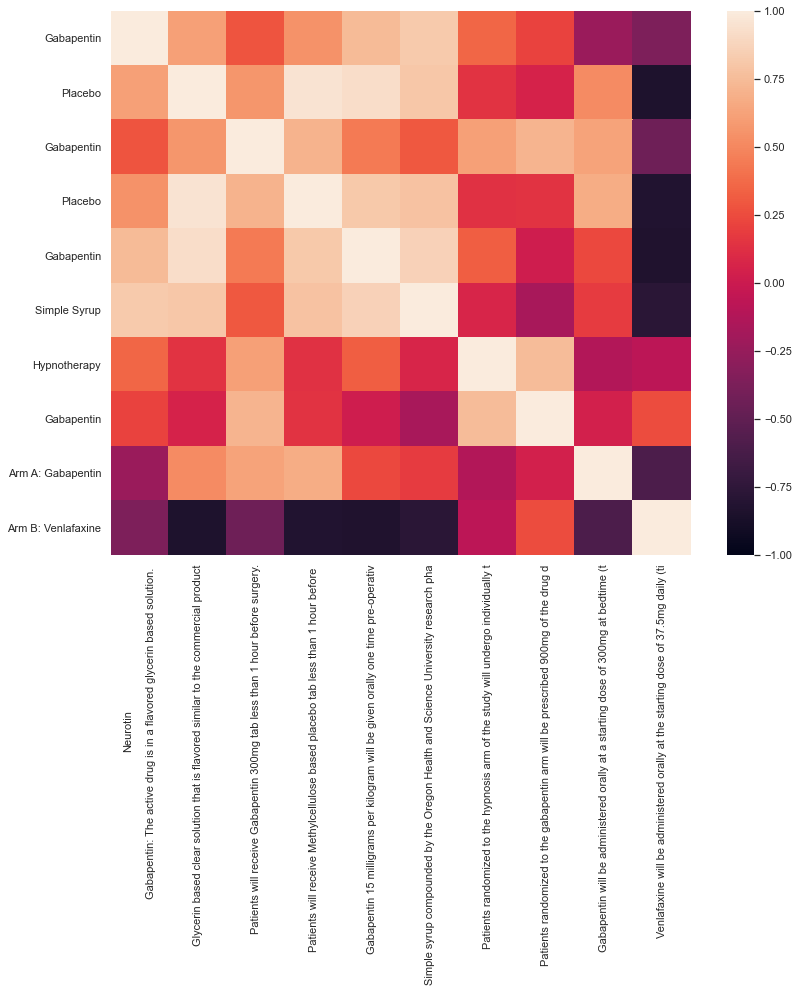

In [105]:
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(13,10))    
x_heatmap_labels = [x[:80] for x in test_group['description'].to_list()]
y_heatmap_labels = test_group['title'].to_list()
sim_matrix = cosine_similarity(np.array(test_group['embedding'].to_list()))
ax = sns.heatmap(sim_matrix, xticklabels=x_heatmap_labels, yticklabels=y_heatmap_labels, vmax=1, vmin=-1, ax=ax)


## Measures
- Time to look at ways to aggregate the measures for cross analysis

Think we have a decent idea of how to do this.
- Use Clinical BERT as a way to make the sentence embeddings then look at the similarity WITHIN DRUG GROUPS

This can be expanded apon a bit more but for now

Apparently we are going to have to a little training, althought that can be saved until the end for finetunning. Let's first get the general pipeline in place

In [10]:
# Create the general sentencee embedding architecture 
from sentence_transformers import SentenceTransformer, models
from transformers import AutoTokenizer, AutoModel

word_embedding_model = models.Transformer('emilyalsentzer/Bio_ClinicalBERT', max_seq_length=256) # Hugging face
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())

model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

In [59]:
# Let's encode all the measures and see 
# Only the ones with a description

no_NA = len(measures_table[measures_table['description'] == 'NA'])
print("There are", no_NA, "measures without a description")
measures_w_desc = measures_table[measures_table['description'] != 'NA']
measures_w_desc.to_pickle('measures_w_desc.pkl')

There are 49 measures without a description


In [9]:
measure_desc_emb = model.encode(measures_w_desc['description'].tolist()) # list of numpy arrays

#### Running some Clustering

In [10]:
from sklearn.cluster import AgglomerativeClustering


cluster = AgglomerativeClustering(n_clusters=4, affinity='cosine', linkage='average').fit(measure_desc_emb)
measures_w_desc['cluster_label'] = pd.Series(cluster.labels_).values

<ipython-input-10-d0096c814d4b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  measures_w_desc['cluster_label'] = pd.Series(cluster.labels_).values


In [11]:
# Yeah it views them all as incredibly similar 
measures_w_desc['cluster_label'].value_counts()

0    891
1      6
2      2
3      1
Name: cluster_label, dtype: int64

In [12]:
# Get a subset of measures to see how it does their similarity
measures_w_desc.to_csv('measures.csv')

In [13]:
hot_flash_measures = [measures_w_desc.at[38, 'description']] + [measures_w_desc.at[41, 'description']]
nausea_measures = [measures_w_desc.at[53, 'description']] + [measures_w_desc.at[81, 'description']] + [measures_w_desc.at[132, 'description']]
pain_measures = [measures_w_desc.at[2, 'description']] + [measures_w_desc.at[51, 'description']] + [measures_w_desc.at[112, 'description']]

test_measures = hot_flash_measures + nausea_measures + pain_measures
test_measures_enc = model.encode(test_measures)

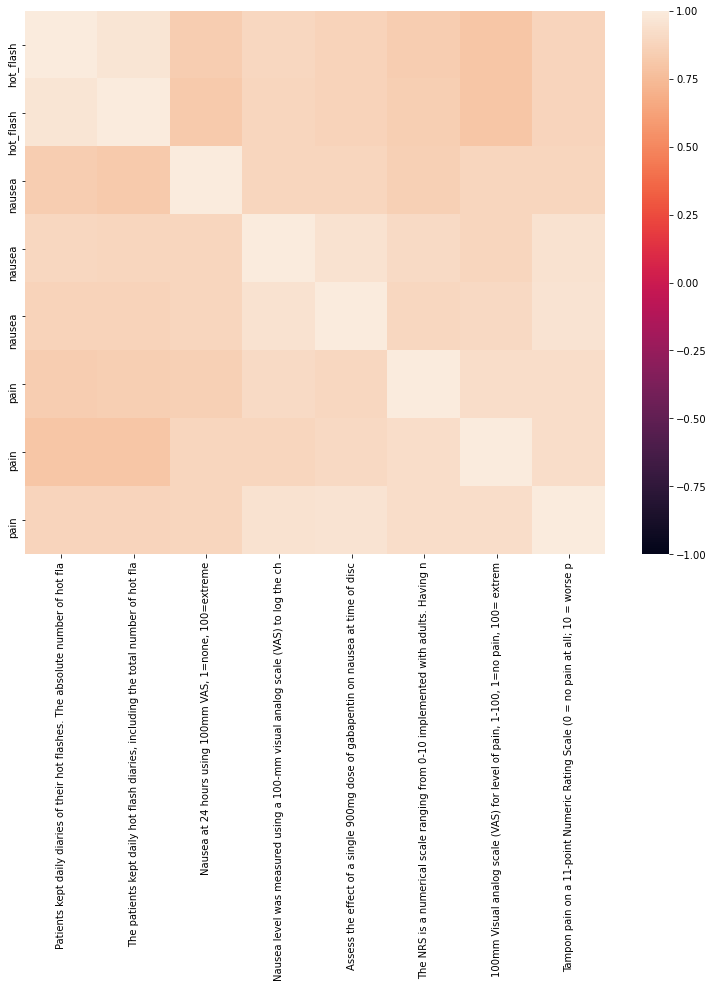

In [14]:
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(13,10))    
x_heatmap_labels = [x[:80] for x in test_measures]
y_heatmap_labels = ['hot_flash']*2 + ['nausea']*3 + ['pain']*3
sim_matrix = cosine_similarity(test_measures_enc)
ax = sns.heatmap(sim_matrix, xticklabels=x_heatmap_labels, yticklabels=y_heatmap_labels, vmax=1, vmin=-1, ax=ax)

#### Fine Tuning the Model

In [7]:
# We need to do some ammount of similarity - so we can use the number of mesh terms each study has in common,
# Let's check out the data and see what we can get out of it
# If they're in the same study and both primary then they're going to be similar
# If they share the same mesh terms and are both primary then they're going to be super similar
# Same conditions can also be added, i.e similarities (save that till the end)
# We should consider the similarity of the mesh terms as well - probably using the condition tree for common ancestors
# We are NOT going to incoporate the tagged treatments used as that would be cheating and ruins the use case

In [11]:
# Gather a bunch of studies
from os import listdir
from os.path import isfile, join, isdir
import json


def sample_studies_with_results(no_studies):
    study_directories = [f for f in listdir('AllAPIJSON/') if isdir(join('AllAPIJSON/', f))]
    studies = []
    for directory in study_directories:
        studyFileNames = [f for f in listdir('AllAPIJSON/'+directory+'/')]
        for file in studyFileNames:
            try:
                with open('AllAPIJSON/'+directory+'/'+file) as f:
                    data = json.load(f)['FullStudy']
                    has_results = 'ResultsSection' in data['Study'] and 'OutcomeMeasuresModule' in data['Study']['ResultsSection']
                    interventions = [x.get('InterventionMeshTerm', 'NA') for x in data['Study']['DerivedSection']['InterventionBrowseModule']['InterventionMeshList']['InterventionMesh']]
                    if has_results and interventions:
                        studies.append(data)


                    f.close()
                if len(studies) > no_studies:
                    return studies
            except KeyError:
                continue
    return studies


more_studies = sample_studies_with_results(500)
more_studies_table = pd.DataFrame.from_dict(create_studies_table(more_studies, 'NA'))
more_measures_table = pd.DataFrame.from_dict(create_measures_table(more_studies))

In [57]:
# Merge measures with studies
measures_studies = more_measures_table[['study_id', 'description', 'type']].merge(more_studies_table, 'inner', ['study_id']).rename(columns=
    {'description_x':'measure_description', 
     'description_y':'study_description',
     'type_x': 'measure_type',
     'type_y': 'study_type'
    })
measures_studies = measures_studies[['study_id', 'measure_description', 'measure_type', 'conditions', 'interventions', 'mesh_terms']].drop_duplicates(
    ['study_id', 'measure_description', 'measure_type'])
measures_studies.to_pickle('measures_studies.pkl')
measures_studies = pd.read_pickle('measures_studies.pkl')


In [58]:
measures_studies

,study_id,measure_description,measure_type,conditions,interventions,mesh_terms
0,NCT03266419,The patient was administered intravenous oxyco...,Primary,[Neuromuscular Blockade],[Rocuronium],[]
1,NCT03266419,The patient was administered intravenous oxyco...,Secondary,[Neuromuscular Blockade],[Rocuronium],[]
2,NCT03262441,Regression slope of change in cell-associated ...,Primary,[Human Immunodeficiency Virus I Infection],[Mycophenolic Acid],"[Acquired Immunodeficiency Syndrome, HIV Infec..."
3,NCT03262441,Regression slope of change in cell-associated ...,Primary,[Human Immunodeficiency Virus I Infection],[Mycophenolic Acid],"[Acquired Immunodeficiency Syndrome, HIV Infec..."
4,NCT03262441,Regression slope of change in cell-associated ...,Primary,[Human Immunodeficiency Virus I Infection],[Mycophenolic Acid],"[Acquired Immunodeficiency Syndrome, HIV Infec..."
...,...,...,...,...,...,...
4114,NCT00875524,Geometric mean titers against each serotype of...,Primary,"[Dengue Virus, Dengue Fever, Dengue Hemorrhagi...",[Vaccines],"[Dengue, Hemorrhagic Fevers, Viral, Severe Den..."
4115,NCT00875524,GMT against each serotype of the parental deng...,Primary,"[Dengue Virus, Dengue Fever, Dengue Hemorrhagi...",[Vaccines],"[Dengue, Hemorrhagic Fevers, Viral, Severe Den..."
4116,NCT00875524,Antibody titer levels against each serotype of...,Primary,"[Dengue Virus, Dengue Fever, Dengue Hemorrhagi...",[Vaccines],"[Dengue, Hemorrhagic Fevers, Viral, Severe Den..."
4118,NCT00875524,"Solicited Inj. site reactions: Pain, Erythema,...",Primary,"[Dengue Virus, Dengue Fever, Dengue Hemorrhagi...",[Vaccines],"[Dengue, Hemorrhagic Fevers, Viral, Severe Den..."


In [29]:
# Lets get percentage of mesh terms first
import math
from sentence_transformers import InputExample

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

def percent_shared(terms_one, terms_two):
    # A simple no_shared / total
    if not terms_one and not terms_two:
        return 0
    
    return len([x for x in terms_one if x in terms_two]) / len(terms_one+terms_two)


In [53]:
import math

prim_measure_studies = measures_studies[measures_studies['measure_type'] == 'Primary']
idxs = prim_measure_studies.index.tolist()
input_examples = []
zero_examples = []
for idx in idxs:
    curr_desc = prim_measure_studies.at[idx, 'measure_description']
    curr_conditions = prim_measure_studies.at[idx, 'conditions']
    curr_interventions = prim_measure_studies.at[idx, 'interventions']
    curr_terms = prim_measure_studies.at[idx, 'mesh_terms']
    curr_id = prim_measure_studies.at[idx, 'study_id']
    
    for idx2 in idxs:
        if idx2 <= idx:
            continue
            
        comp_desc = prim_measure_studies.at[idx2, 'measure_description']
        comp_conditions = prim_measure_studies.at[idx2, 'conditions']
        comp_interventions = prim_measure_studies.at[idx2, 'interventions']
        comp_terms = prim_measure_studies.at[idx2, 'mesh_terms']
        comp_id = prim_measure_studies.at[idx2, 'study_id']
        
        mesh_score = percent_shared(curr_terms, comp_terms) # between 0 and 1
        conditions_score = percent_shared(curr_conditions, comp_conditions) # between 0 and 1
        ints_score = percent_shared(curr_interventions, comp_interventions) # between 0 and 1
        scores = [mesh_score, conditions_score, ints_score]
        scores.sort(reverse=True)
        floor = .9 if comp_id == curr_id else 0
        
        sim_label = (scores[0] + scores[1] + scores[2]) / 3
        if sim_label > 0:
            input_examples.append(InputExample(texts=[curr_desc, comp_desc], label=max(sim_label, floor)))
        else:
            zero_examples.append(InputExample(texts=[curr_desc, comp_desc], label=max(sim_label, floor)))
        

In [54]:
len(input_examples)

13245

In [44]:
from sentence_transformers import SentenceTransformer, InputExample, losses, evaluation
from torch.utils.data import DataLoader

# sentences1 = ['This list contains the first column', 'With your sentences', 'You want your model to evaluate on']
# sentences2 = ['Sentences contains the other column', 'The evaluator matches sentences1[i] with sentences2[i]', 'Compute the cosine similarity and compares it to scores[i]']
# scores = [0.3, 0.6, 0.2]

# evaluator = evaluation.EmbeddingSimilarityEvaluator(sentences1, sentences2, scores)

#Define your train dataset, the dataloader and the train loss
train_dataloader = DataLoader(input_examples[:600] + zero_examples[:100], shuffle=True, batch_size=20) # give it 500 to keep training time reasonable
train_loss = losses.CosineSimilarityLoss(model)


model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=2)

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

AttributeError: 'float' object has no attribute 'strip'

In [35]:
measures_studies.at[2, 'measure_description']

'Regression slope of change in cell-associated HIV DNA (ca-DNA) as measured by multiplexed digital droplet PCR in study participants on MMF calculated from 4 time points between 0 & 12 months'

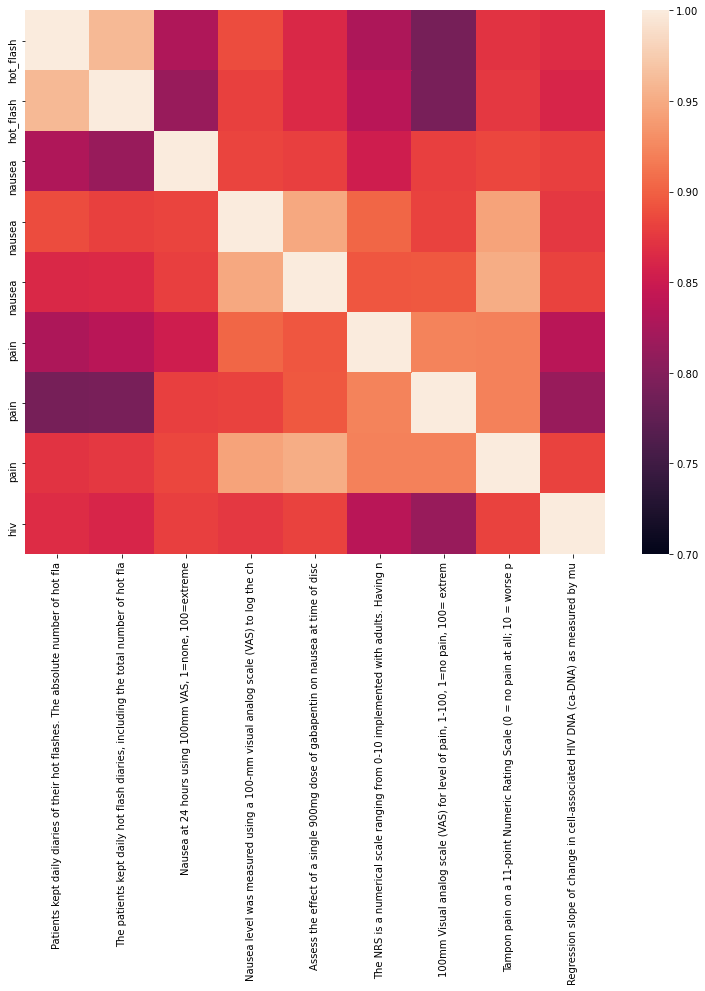

In [24]:
hot_flash_measures = [measures_w_desc.at[38, 'description']] + [measures_w_desc.at[41, 'description']]
nausea_measures = [measures_w_desc.at[53, 'description']] + [measures_w_desc.at[81, 'description']] + [measures_w_desc.at[132, 'description']]
pain_measures = [measures_w_desc.at[2, 'description']] + [measures_w_desc.at[51, 'description']] + [measures_w_desc.at[112, 'description']]
hiv_measure = [measures_studies.at[2, 'measure_description']]
test_measures = hot_flash_measures + nausea_measures + pain_measures + hiv_measure
test_measures_enc = model.encode(test_measures)

from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(13,10))    
x_heatmap_labels = [x[:80] for x in test_measures]
y_heatmap_labels = ['hot_flash']*2 + ['nausea']*3 + ['pain']*3 + ['hiv']
sim_matrix = cosine_similarity(test_measures_enc)
ax = sns.heatmap(sim_matrix, xticklabels=x_heatmap_labels, yticklabels=y_heatmap_labels, vmax=1, vmin=.7, ax=ax)

### Balanced Conditions Data
- We want our measures to represent the conditions it's being used to treat so let's get some studies with a wide varaiety of conditions

In [65]:
def sample_studies_with_results_and_conditions(no_studies):
    study_directories = [f for f in listdir('AllAPIJSON/') if isdir(join('AllAPIJSON/', f))]
    studies = []
    for directory in study_directories:
        studyFileNames = [f for f in listdir('AllAPIJSON/'+directory+'/')]
        for file in studyFileNames:
            try:
                with open('AllAPIJSON/'+directory+'/'+file) as f:
                    data = json.load(f)['FullStudy']
                    has_results = 'ResultsSection' in data['Study'] and 'OutcomeMeasuresModule' in data['Study']['ResultsSection']
                    interventions = [x.get('InterventionMeshTerm', 'NA') for x in data['Study']['DerivedSection']['InterventionBrowseModule']['InterventionMeshList']['InterventionMesh']]
                    conditions = study['Study']['ProtocolSection']['ConditionsModule']['ConditionList']['Condition']
                    if has_results and interventions and conditions:
                        studies.append(data)
                    

                    f.close()
                if len(studies) > no_studies:
                    return studies
            except KeyError:
                continue
    return studies


condition_studies = sample_studies_with_results(1000)
condition_studies_table = pd.DataFrame.from_dict(create_studies_table(condition_studies, 'NA'))
condition_measures_table = pd.DataFrame.from_dict(create_measures_table(condition_studies))


In [68]:
condition_measures_table

,study_id,measure,type,description,dispersion_param,measure_param,units
0,NCT03266419,Minimum Effective Analgesic Dose (MEAD) of Oxy...,Primary,The patient was administered intravenous oxyco...,Full Range,Median,mg
1,NCT03266419,Mean Visual Analogue Scale (VAS) Score for Wou...,Secondary,The patient was administered intravenous oxyco...,Full Range,Mean,mm
2,NCT03262441,Change in Cell-associated HIV DNA (Ca-DNA) Lev...,Primary,Regression slope of change in cell-associated ...,95% Confidence Interval,Mean,log10 caDNA copies per 10^6 T-cells/week
3,NCT03262441,Change in Cell-associated HIV DNA (Ca-DNA) Lev...,Primary,Regression slope of change in cell-associated ...,95% Confidence Interval,Mean,log10 caDNA copies per 10^6 T-cells/week
4,NCT03262441,Change in Cell-associated Intact HIV DNA (Ca-i...,Primary,Regression slope of change in cell-associated ...,95% Confidence Interval,Mean,log10 caDNA copies per 10^6 T-cells/week
...,...,...,...,...,...,...,...
7749,NCT00447057,Time to Treatment Failure (TTTF),Secondary,Defined as the time from randomization to deat...,95% Confidence Interval,Median,months
7750,NCT00447057,Overall Survival (OS),Secondary,OS time is the duration from randomization to ...,95% Confidence Interval,Median,months
7751,NCT00447057,Percentage of Participants Surviving at 1 Year,Secondary,Overall Survival (OS) rate at 1 year from the ...,95% Confidence Interval,Median,Percentage participants with OS ≥1 year
7752,NCT00447057,Number of Participants With Adverse Events (AEs),Secondary,Summaries of serious AEs (SAEs) and all other ...,NA,Number,participants


In [66]:
# Merge measures with studies
condition_measures_studies = condition_measures_table[['study_id', 'description', 'type']].merge(condition_studies_table, 'inner', ['study_id']).rename(columns=
    {'description_x':'measure_description', 
     'description_y':'study_description',
     'type_x': 'measure_type',
     'type_y': 'study_type'
    })
condition_measures_studies = condition_measures_studies[['study_id', 'measure_description', 'measure_type', 'conditions', 'interventions', 'mesh_terms']].drop_duplicates(
    ['study_id', 'measure_description', 'measure_type'])
condition_measures_studies.to_pickle('condition_measures_studies.pkl')
condition_measures_studies = pd.read_pickle('condition_measures_studies.pkl')


## Statistics
- Create and merge our stats tables with other parts of the project

In [69]:
analytics_table

,study_id,measure,groups,description,method,param_type,fromStudy,pval,group_titles
0,NCT02359110,NRS (Numerical Rating Scale),"[OG000, OG001]",Hour 2 Analysis,Mixed Models Analysis,Mean Difference (Final Values),True,0.89,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}"
1,NCT02359110,NRS (Numerical Rating Scale),"[OG000, OG001]",Hour 4 Analysis,Mixed Models Analysis,Mean Difference (Final Values),True,0.94,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}"
2,NCT02359110,NRS (Numerical Rating Scale),"[OG000, OG001]",Hour 6 Analysis,Mixed Models Analysis,Mean Difference (Final Values),True,0.64,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}"
3,NCT02359110,NRS (Numerical Rating Scale),"[OG000, OG001]",Hour 8 Analysis,Mixed Models Analysis,Mean Difference (Final Values),True,0.59,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}"
4,NCT02359110,VAS (Visual Analog Scale),"[OG000, OG001]",Hour 2 Analysis,Mixed Models Analysis,Mean Difference (Final Values),True,0.52,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}"
...,...,...,...,...,...,...,...,...,...
1969,NCT01524796,Change From Baseline In Worst Pain Level At Mo...,[OG000],NA,Wilcoxon signed-rank test,NA,True,<0.001,{'OG000': 'Pregabalin'}
1970,NCT01524796,Change From Baseline In Least Pain Level At Mo...,[OG000],NA,Wilcoxon signed-rank test,NA,True,<0.001,{'OG000': 'Pregabalin'}
1971,NCT00667342,Mean Ktrans,[OG000],NA,Logistic Regression,NA,True,0.0863,{'OG000': 'A: Localized Resectable Disease'}
1972,NCT00667342,Mean Vp,[OG000],NA,Logistic Regression,NA,True,0.0573,{'OG000': 'A: Localized Resectable Disease'}


In [80]:
measures_table

,study_id,measure,type,description,dispersion_param,measure_param,units
0,NCT01675960,Symptom Relief for Chronic Irritability in Neu...,Primary,We will determine whether gabapentin provides ...,NA,NA,NA
1,NCT01675960,Prevalence of Associated Gastrointestinal and ...,Secondary,We will attempt to identify gastrointestinal a...,NA,NA,NA
2,NCT02359110,NRS (Numerical Rating Scale),Primary,The NRS is a numerical scale ranging from 0-10...,95% Confidence Interval,Least Squares Mean,units on a scale
3,NCT02359110,VAS (Visual Analog Scale),Secondary,The VAS is scored using a horizontal line 100m...,95% Confidence Interval,Least Squares Mean,units on a scale
4,NCT02359110,Total Morphine Consumption,Secondary,NA,Standard Deviation,Mean,mg
...,...,...,...,...,...,...,...
944,NCT00667342,Number of Participants With Neuropathic Pain (...,Other Pre-specified,"Of the 43 participants enrolled on this trial,...",NA,Number,participants
945,NCT00667342,Median Duration of Neuropathic Pain,Other Pre-specified,Thirty participants who underwent surgery (31 ...,Full Range,Median,Weeks
946,NCT00667342,Mean Duration of Neuropathic Pain,Other Pre-specified,Thirty participants who underwent surgery (31 ...,Standard Deviation,Mean,Weeks
947,NCT00667342,Median Duration of Neuropathic Pain Medication,Other Pre-specified,Thirty participants who underwent surgery (31 ...,Full Range,Median,Weeks


In [14]:
import pickle
def load_pickle5_file(filepath):
    data = None
    with open(filepath, "rb") as fh:
        data = pickle.load(fh)
    return data

In [16]:
# Get all intervention studies
intervention_studies_1 = load_pickle5_file('intervention_studies_1.pkl')
intervention_studies_0 = load_pickle5_file('intervention_studies_0.pkl')
intervention_studies_2 = load_pickle5_file('intervention_studies_2.pkl')

intervention_studies = pd.concat([intervention_studies_1, intervention_studies_0, intervention_studies_2])

# Get all intervention measures
intervention_measures_1 = load_pickle5_file('int_measures_1.pkl')
intervention_measures_0 = load_pickle5_file('int_measures_0.pkl')
intervention_measures_2 = load_pickle5_file('int_measures_2.pkl')

intervention_measures = pd.concat([intervention_measures_1, intervention_measures_0, intervention_measures_2])

# Get all intervention outcomes
intervention_outcomes_1 = load_pickle5_file('int_outcomes_1.pkl')
intervention_outcomes_0 = load_pickle5_file('int_outcomes_0.pkl')
intervention_outcomes_2 = load_pickle5_file('int_outcomes_2.pkl')

intervention_outcomes = pd.concat([intervention_outcomes_1, intervention_outcomes_0, intervention_outcomes_2])

# Get all intervention admins
intervention_admins_1 = load_pickle5_file('int_admins_1.pkl')
intervention_admins_0 = load_pickle5_file('int_admins_0.pkl')
intervention_admins_2 = load_pickle5_file('int_admins_2.pkl')

intervention_admins = pd.concat([intervention_admins_1, intervention_admins_0, intervention_admins_2])

In [18]:
# Let's make our stats rows
base = intervention_admins.merge(intervention_outcomes, 'outer', ['study_id', 'group_id', 'measure']).rename(columns={
    'title_x': 'group_title',
    'title_y': 'outcome_title'
})
base = base.merge(intervention_measures, 'left', ['study_id', 'measure']).drop_duplicates().rename(columns={
    'description_x': 'group_description',
    'description_y': 'measure_description'
})
base = base.fillna('NA')
base.head()

,study_id,group_id,measure,group_title,group_description,outcome_title,value,dispersion,upper,lower,participants,type,measure_description,dispersion_param,measure_param,units
0,NCT00262834,OG000,Number of Participants With Adverse Events,Vorinostat,Women in the vorinostat group were scheduled t...,NA,17,NA,NA,NA,25,Primary,Participants were evaluated for adverse events...,NA,Number,participants
1,NCT00262834,OG000,Change in Tissue Proliferation After 3 Days of...,Vorinostat,Women in the vorinostat group were scheduled t...,NA,-3,NA,38,-62,25,Primary,Change in Ki-67 (a marker of tissue proliferat...,Full Range,Mean,percentage of change
2,NCT00262834,OG001,Change in Tissue Proliferation After 3 Days of...,Tissue Only,Women who declined vorinostat but agreed to do...,NA,-4,NA,46,-32,29,Primary,Change in Ki-67 (a marker of tissue proliferat...,Full Range,Mean,percentage of change
3,NCT00262834,OG000,Change in Tissue Apoptosis After 3 Days of Tre...,Vorinostat,Women in the vorinostat group were scheduled t...,NA,0,NA,5,-5,25,Primary,Change in cleaved caspase-3 (a marker of tissu...,Full Range,Mean,percentage of change
4,NCT00262834,OG001,Change in Tissue Apoptosis After 3 Days of Tre...,Tissue Only,Women who declined vorinostat but agreed to do...,NA,0,NA,3,-2,29,Primary,Change in cleaved caspase-3 (a marker of tissu...,Full Range,Mean,percentage of change


In [19]:
import scipy.stats as stats
import math

def get_sd(outcome_spread, ranges, value, no_obs):
    try:
        if outcome_spread == 'Standard Error':
            return math.sqrt(no_obs) * float(ranges) # assuming ranges is one number in this case

        if outcome_spread == '95% Confidence Interval':
            return math.sqrt(int(no_obs)) * (float(ranges[1]) - float(ranges[0])) / 3.92

        if outcome_spread == 'Standard Deviation':
            if isinstance(ranges, tuple):
                return -2
            return float(ranges)

        if outcome_spread == "Inter-Quartile Range":
            return (float(ranges[1]) - float(ranges[0])) / 1.35 # Assuming the distribution is normal 
        
    except ValueError as e: # A little too catch-all imo, this whole system needs to be reworked
        return -1
    
    return -1

def get_ranges(row):
    if row.dispersion_param in ['Inter-Quartile Range', '95% Confidence Interval']:
        return (row.lower, row.upper)
  
    return row.dispersion


def get_pval(row_a, row_b):
    mean1 = float(row_a.value.replace(',','')) if row_a.value != 'NA' else -1
    ranges1 = get_ranges(row_a)
    nobs1 = int(row_a.participants.replace(',','')) if row_a.participants != 'NA' else -1
    
    mean2 = float(row_b.value.replace(',','')) if row_b.value != 'NA' else -1
    ranges2 = get_ranges(row_b)
    nobs2 = int(row_b.participants.replace(',','')) if row_b.participants != 'NA' else -1
    
    if (-1 in {mean1, nobs1, mean2, nobs2}):
        return -1

    if nobs1+nobs2 <= 2:
        return -1

    std2 = get_sd(row_a.dispersion_param, ranges2, mean2, nobs2)
    std1 = get_sd(row_a.dispersion_param, ranges1, mean1, nobs1)
    
    if (-2 in {std1, std2}):
        return -1
    
    if (-1 in {std1, std2}):
        return -1
    
    p_val = stats.ttest_ind_from_stats(mean1=mean1, std1=std1, nobs1=nobs1,mean2=mean2, std2=std2, nobs2=nobs2).pvalue
    
    return float(p_val)

In [23]:
# We need to create a seperate table to hold the comparisons between the different groups
# We should make entries into the existing analytics table
new_analysis = {
    'study_id': [],
    'measure': [],
    'groups': [],
    'description': [],
    'method': [],
    'param_type': [],
    'fromStudy': [],
    'pval': [],
    'group_titles': []
}
error_counter = 1
study_ids = intervention_studies['study_id'].tolist()
for study_id in study_ids:
    # Select all measures with that study
    base_group = base[base['study_id']==study_id]
    measures = list(base_group['measure'].value_counts().keys())
    
    for measure in measures:
        measure_group = base_group[base_group['measure'] == measure]
        outcome_titles = list(measure_group['outcome_title'].value_counts().keys()) # Need to fill in the NaNs before
        for outcome_title in outcome_titles:
            outcome_group = measure_group[measure_group['outcome_title'] == outcome_title]
            groups = list(outcome_group['group_id'].value_counts().keys())
            for i in range(len(groups)):
                for j in range(len(groups)):
                    if i<=j:
                        continue

                    group_a = groups[i]
                    group_b = groups[j]
                    
                    row_a = outcome_group[outcome_group['group_id'] == group_a].iloc[0] # This should be one single row
                    row_b = outcome_group[outcome_group['group_id'] == group_b].iloc[0]
                    try:
                        pval = get_pval(row_a, row_b)
                    except ValueError as e:
                        print(error_counter)
                        error_counter += 1
                        continue
                    
                    new_analysis['study_id'].append(study_id)
                    new_analysis['measure'].append(measure)
                    new_analysis['groups'].append([group_a, group_b])
                    new_analysis['description'].append(outcome_title)
                    new_analysis['method'].append('t-test')
                    new_analysis['param_type'].append('?')
                    new_analysis['fromStudy'].append(False)
                    new_analysis['pval'].append(pval)
                    new_analysis['group_titles'].append({group_a: row_a['group_title'], group_b: row_b['group_title']})

    
                    
            
            
            

1
2
3
4
5


In [24]:
new_analytics_table = pd.DataFrame.from_dict(new_analysis)
new_analytics_table.to_pickle('int_analytics.pkl')

In [27]:
new_analytics_table[new_analytics_table['pval'] != -1]['study_id'].value_counts()

NCT02055976    10419
NCT00550446     9522
NCT00413660     8636
NCT00328627     8491
NCT02038907     8039
               ...  
NCT01125163        1
NCT01765543        1
NCT01439282        1
NCT02603107        1
NCT01539538        1
Name: study_id, Length: 16366, dtype: int64

In [28]:
new_analytics_table[new_analytics_table['study_id'] == 'NCT02055976']

,study_id,measure,groups,description,method,param_type,fromStudy,pval,group_titles
425254,NCT02055976,Apolipoprotein B (ApoB),"[OG006, OG003]",Day 29,t-test,?,False,2.078935e-16,"{'OG006': 'PF-04950615 100 mg', 'OG003': 'Ator..."
425255,NCT02055976,Apolipoprotein B (ApoB),"[OG005, OG003]",Day 29,t-test,?,False,9.608038e-07,"{'OG005': 'PF-04950615 50 mg', 'OG003': 'Atorv..."
425256,NCT02055976,Apolipoprotein B (ApoB),"[OG005, OG006]",Day 29,t-test,?,False,2.805191e-03,"{'OG005': 'PF-04950615 50 mg', 'OG006': 'PF-04..."
425257,NCT02055976,Apolipoprotein B (ApoB),"[OG000, OG003]",Day 29,t-test,?,False,2.017043e-14,"{'OG000': 'Atorvastatin + PF-04950615 50 mg', ..."
425258,NCT02055976,Apolipoprotein B (ApoB),"[OG000, OG006]",Day 29,t-test,?,False,6.100394e-01,"{'OG000': 'Atorvastatin + PF-04950615 50 mg', ..."
...,...,...,...,...,...,...,...,...,...
436051,NCT02055976,Minimum Observed Plasma Trough Concentration (...,"[OG002, OG003]",NA,t-test,?,False,-1.000000e+00,"{'OG002': 'Atorvastatin + PF-04950615 150 mg',..."
436052,NCT02055976,Minimum Observed Plasma Trough Concentration (...,"[OG002, OG001]",NA,t-test,?,False,-1.000000e+00,"{'OG002': 'Atorvastatin + PF-04950615 150 mg',..."
436053,NCT02055976,Minimum Observed Plasma Trough Concentration (...,"[OG002, OG000]",NA,t-test,?,False,-1.000000e+00,"{'OG002': 'Atorvastatin + PF-04950615 150 mg',..."
436054,NCT02055976,Minimum Observed Plasma Trough Concentration (...,"[OG002, OG004]",NA,t-test,?,False,-1.000000e+00,"{'OG002': 'Atorvastatin + PF-04950615 150 mg',..."


In [49]:
measures_table.head()

,study_id,measure,type,description,dispersion_param,measure_param,units
0,NCT01675960,Symptom Relief for Chronic Irritability in Neu...,Primary,We will determine whether gabapentin provides ...,NA,NA,NA
1,NCT01675960,Prevalence of Associated Gastrointestinal and ...,Secondary,We will attempt to identify gastrointestinal a...,NA,NA,NA
2,NCT02359110,NRS (Numerical Rating Scale),Primary,The NRS is a numerical scale ranging from 0-10...,95% Confidence Interval,Least Squares Mean,units on a scale
3,NCT02359110,VAS (Visual Analog Scale),Secondary,The VAS is scored using a horizontal line 100m...,95% Confidence Interval,Least Squares Mean,units on a scale
4,NCT02359110,Total Morphine Consumption,Secondary,NA,Standard Deviation,Mean,mg


In [51]:
new_analytics_table.merge(measures_table[['study_id', 'measure', 'description']], 'left', ['study_id', 'measure'])

,study_id,measure,groups,description_x,method,param_type,fromStudy,pval,group_titles,description_y
0,NCT01675960,Symptom Relief for Chronic Irritability in Neu...,"[OG000, OG001]",NA,t-test,?,False,-1.000000,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}",We will determine whether gabapentin provides ...
1,NCT01675960,Prevalence of Associated Gastrointestinal and ...,"[OG000, OG001]",NA,t-test,?,False,-1.000000,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}",We will attempt to identify gastrointestinal a...
2,NCT02359110,NRS (Numerical Rating Scale),"[OG000, OG001]",Hour 6,t-test,?,False,0.588966,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}",The NRS is a numerical scale ranging from 0-10...
3,NCT02359110,NRS (Numerical Rating Scale),"[OG000, OG001]",Hour 4,t-test,?,False,0.904472,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}",The NRS is a numerical scale ranging from 0-10...
4,NCT02359110,NRS (Numerical Rating Scale),"[OG000, OG001]",Hour 8,t-test,?,False,0.601284,"{'OG000': 'Gabapentin', 'OG001': 'Placebo'}",The NRS is a numerical scale ranging from 0-10...
...,...,...,...,...,...,...,...,...,...,...
5860,NCT00667342,Mean Duration of Neuropathic Pain,"[OG000, OG001]",NA,t-test,?,False,0.421641,"{'OG000': 'Amputation Group', 'OG001': 'Limb S...",Thirty participants who underwent surgery (31 ...
5861,NCT00667342,Mean Duration of Neuropathic Pain,"[OG000, OG002]",NA,t-test,?,False,0.509750,"{'OG000': 'Amputation Group', 'OG002': 'Entire...",Thirty participants who underwent surgery (31 ...
5862,NCT00667342,Number of Participants With Neuropathic Pain (...,"[OG002, OG001]",NA,t-test,?,False,-1.000000,"{'OG002': 'Entire Study Group', 'OG001': 'Limb...","Of the 43 participants enrolled on this trial,..."
5863,NCT00667342,Number of Participants With Neuropathic Pain (...,"[OG000, OG001]",NA,t-test,?,False,-1.000000,"{'OG000': 'Amputation Group', 'OG001': 'Limb S...","Of the 43 participants enrolled on this trial,..."


In [90]:
import scipy.stats as stats
import math

def get_sd(outcome_spread, ranges, value, no_obs):
    try:
        if outcome_spread == 'Standard Error':
            return math.sqrt(no_obs) * float(ranges) # assuming ranges is one number in this case

        if outcome_spread == '95% Confidence Interval':
            return math.sqrt(int(no_obs)) * (float(ranges[1]) - float(ranges[0])) / 3.92

        if outcome_spread == 'Standard Deviation':
            if isinstance(ranges, tuple):
                return -2
            return float(ranges)

        if outcome_spread == "Inter-Quartile Range":
            return (float(ranges[1]) - float(ranges[0])) / 1.35 # Assuming the distribution is normal 
        
    except ValueError as e: # A little too catch-all imo, this whole system needs to be reworked
        return -1
    
    return -1

def get_ranges(row):
    if row.dispersion_param in ['Inter-Quartile Range', '95% Confidence Interval']:
        return (row.lower, row.upper)
  
    return row.dispersion


def get_pval(row_a, row_b):
    mean1 = float(row_a.value.replace(',','')) if row_a.value != 'NA' else -1
    ranges1 = get_ranges(row_a)
    nobs1 = int(row_a.participants.replace(',','')) if row_a.participants != 'NA' else -1
    
    mean2 = float(row_b.value.replace(',','')) if row_b.value != 'NA' else -1
    ranges2 = get_ranges(row_b)
    nobs2 = int(row_b.participants.replace(',','')) if row_b.participants != 'NA' else -1
    
    if (-1 in {mean1, nobs1, mean2, nobs2}):
        return -1

    if nobs1+nobs2 <= 2:
        return -1

    std2 = get_sd(row_a.dispersion_param, ranges2, mean2, nobs2)
    std1 = get_sd(row_a.dispersion_param, ranges1, mean1, nobs1)
    
    if (-2 in {std1, std2}):
        return -1
    
    if (-1 in {std1, std2}):
        return -1
    
    p_val = stats.ttest_ind_from_stats(mean1=mean1, std1=std1, nobs1=nobs1,mean2=mean2, std2=std2, nobs2=nobs2).pvalue
    
    return float(p_val)

In [91]:
p_vals = pd.Series(base.apply(lambda x: get_pval(x), axis=1))
base['p_vals_derived'] = p_vals

AttributeError: 'Series' object has no attribute 'control_value'

## Misc

In [39]:
# Parsing and reading a tagged tsv file
tuples = []
with open('train.tsv', 'r') as f:
    large_string = f.read()

In [41]:
lines = large_string.split('\n')

In [61]:
tuples = []
for line in lines:
    try:
        words = line.split('\t')
        tuples.append((words[0], words[1]))
    except IndexError as e:
        continue

In [63]:
len(tuples)

118170

In [68]:
for tup in tuples:
    if len(tup[0].split(' ')) != 1:
        print(tup[0])

In [4]:
# Get all intervention studies
intervention_studies_1 = pd.read_pickle('intervention_studies_1.pkl')
intervention_studies_0 = pd.read_pickle('intervention_studies_0.pkl')
intervention_studies_2 = pd.read_pickle('intervention_studies_2.pkl')

intervention_studies = pd.concat([intervention_studies_1, intervention_studies_0, intervention_studies_2])

# Get all intervention measures
intervention_measures_1 = pd.read_pickle('int_measures_1.pkl')
intervention_measures_0 = pd.read_pickle('int_measures_0.pkl')
intervention_measures_2 = pd.read_pickle('int_measures_2.pkl')

intervention_measures = pd.concat([intervention_measures_1, intervention_measures_0, intervention_measures_2])

# Get all intervention outcomes
intervention_outcomes_1 = pd.read_pickle('int_outcomes_1.pkl')
intervention_outcomes_0 = pd.read_pickle('int_outcomes_0.pkl')
intervention_outcomes_2 = pd.read_pickle('int_outcomes_2.pkl')

intervention_outcomes = pd.concat([intervention_outcomes_1, intervention_outcomes_0, intervention_outcomes_2])

# Get all intervention admins
intervention_admins_1 = pd.read_pickle('int_admins_1.pkl')
intervention_admins_0 = pd.read_pickle('int_admins_0.pkl')
intervention_admins_2 = pd.read_pickle('int_admins_2.pkl')

intervention_admins = pd.concat([intervention_admins_1, intervention_admins_0, intervention_admins_2])

In [7]:
intervention_studies = intervention_studies.reset_index(drop=True)
intervention_admins = intervention_admins.reset_index(drop=True)
intervention_outcomes = intervention_outcomes.reset_index(drop=True)
intervention_measures = intervention_measures.reset_index(drop=True)

In [8]:
intervention_studies.to_csv('intervention_studies.csv')
intervention_admins.to_csv('intervention_admins.csv')
intervention_outcomes.to_csv('intervention_outcomes.csv')
intervention_measures.to_csv('intervention_measures.csv')

## Project Evaluation

In [4]:
int_admins_sample = pd.read_pickle('int_admins_sample.pkl')

In [6]:
evaluation_sample = int_admins_sample.sample(n=100)

In [7]:
evaluation_sample.to_csv('NER_Project_Eval.csv')